In [246]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from random import randint

from imblearn.over_sampling import ADASYN
import xgboost as xgb

import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from CHAID import Tree
from optbinning import OptimalBinning
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor

from hyperopt import fmin, hp, tpe, Trials
from hyperopt.pyll.base import scope
from functools import partial
from hyperopt import base
base.have_bson = False

In [247]:
pd.set_option('display.max_columns', 95)
df = pd.read_csv('_BANKRUPTCY PREDICTION .csv')

In [248]:
print(df['Bankrupt'].value_counts(normalize=True))

0    0.967737
1    0.032263
Name: Bankrupt, dtype: float64


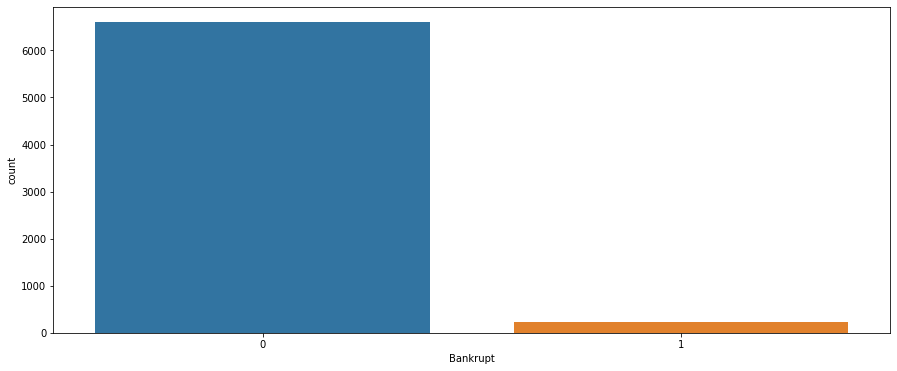

In [249]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Bankrupt')
plt.show()

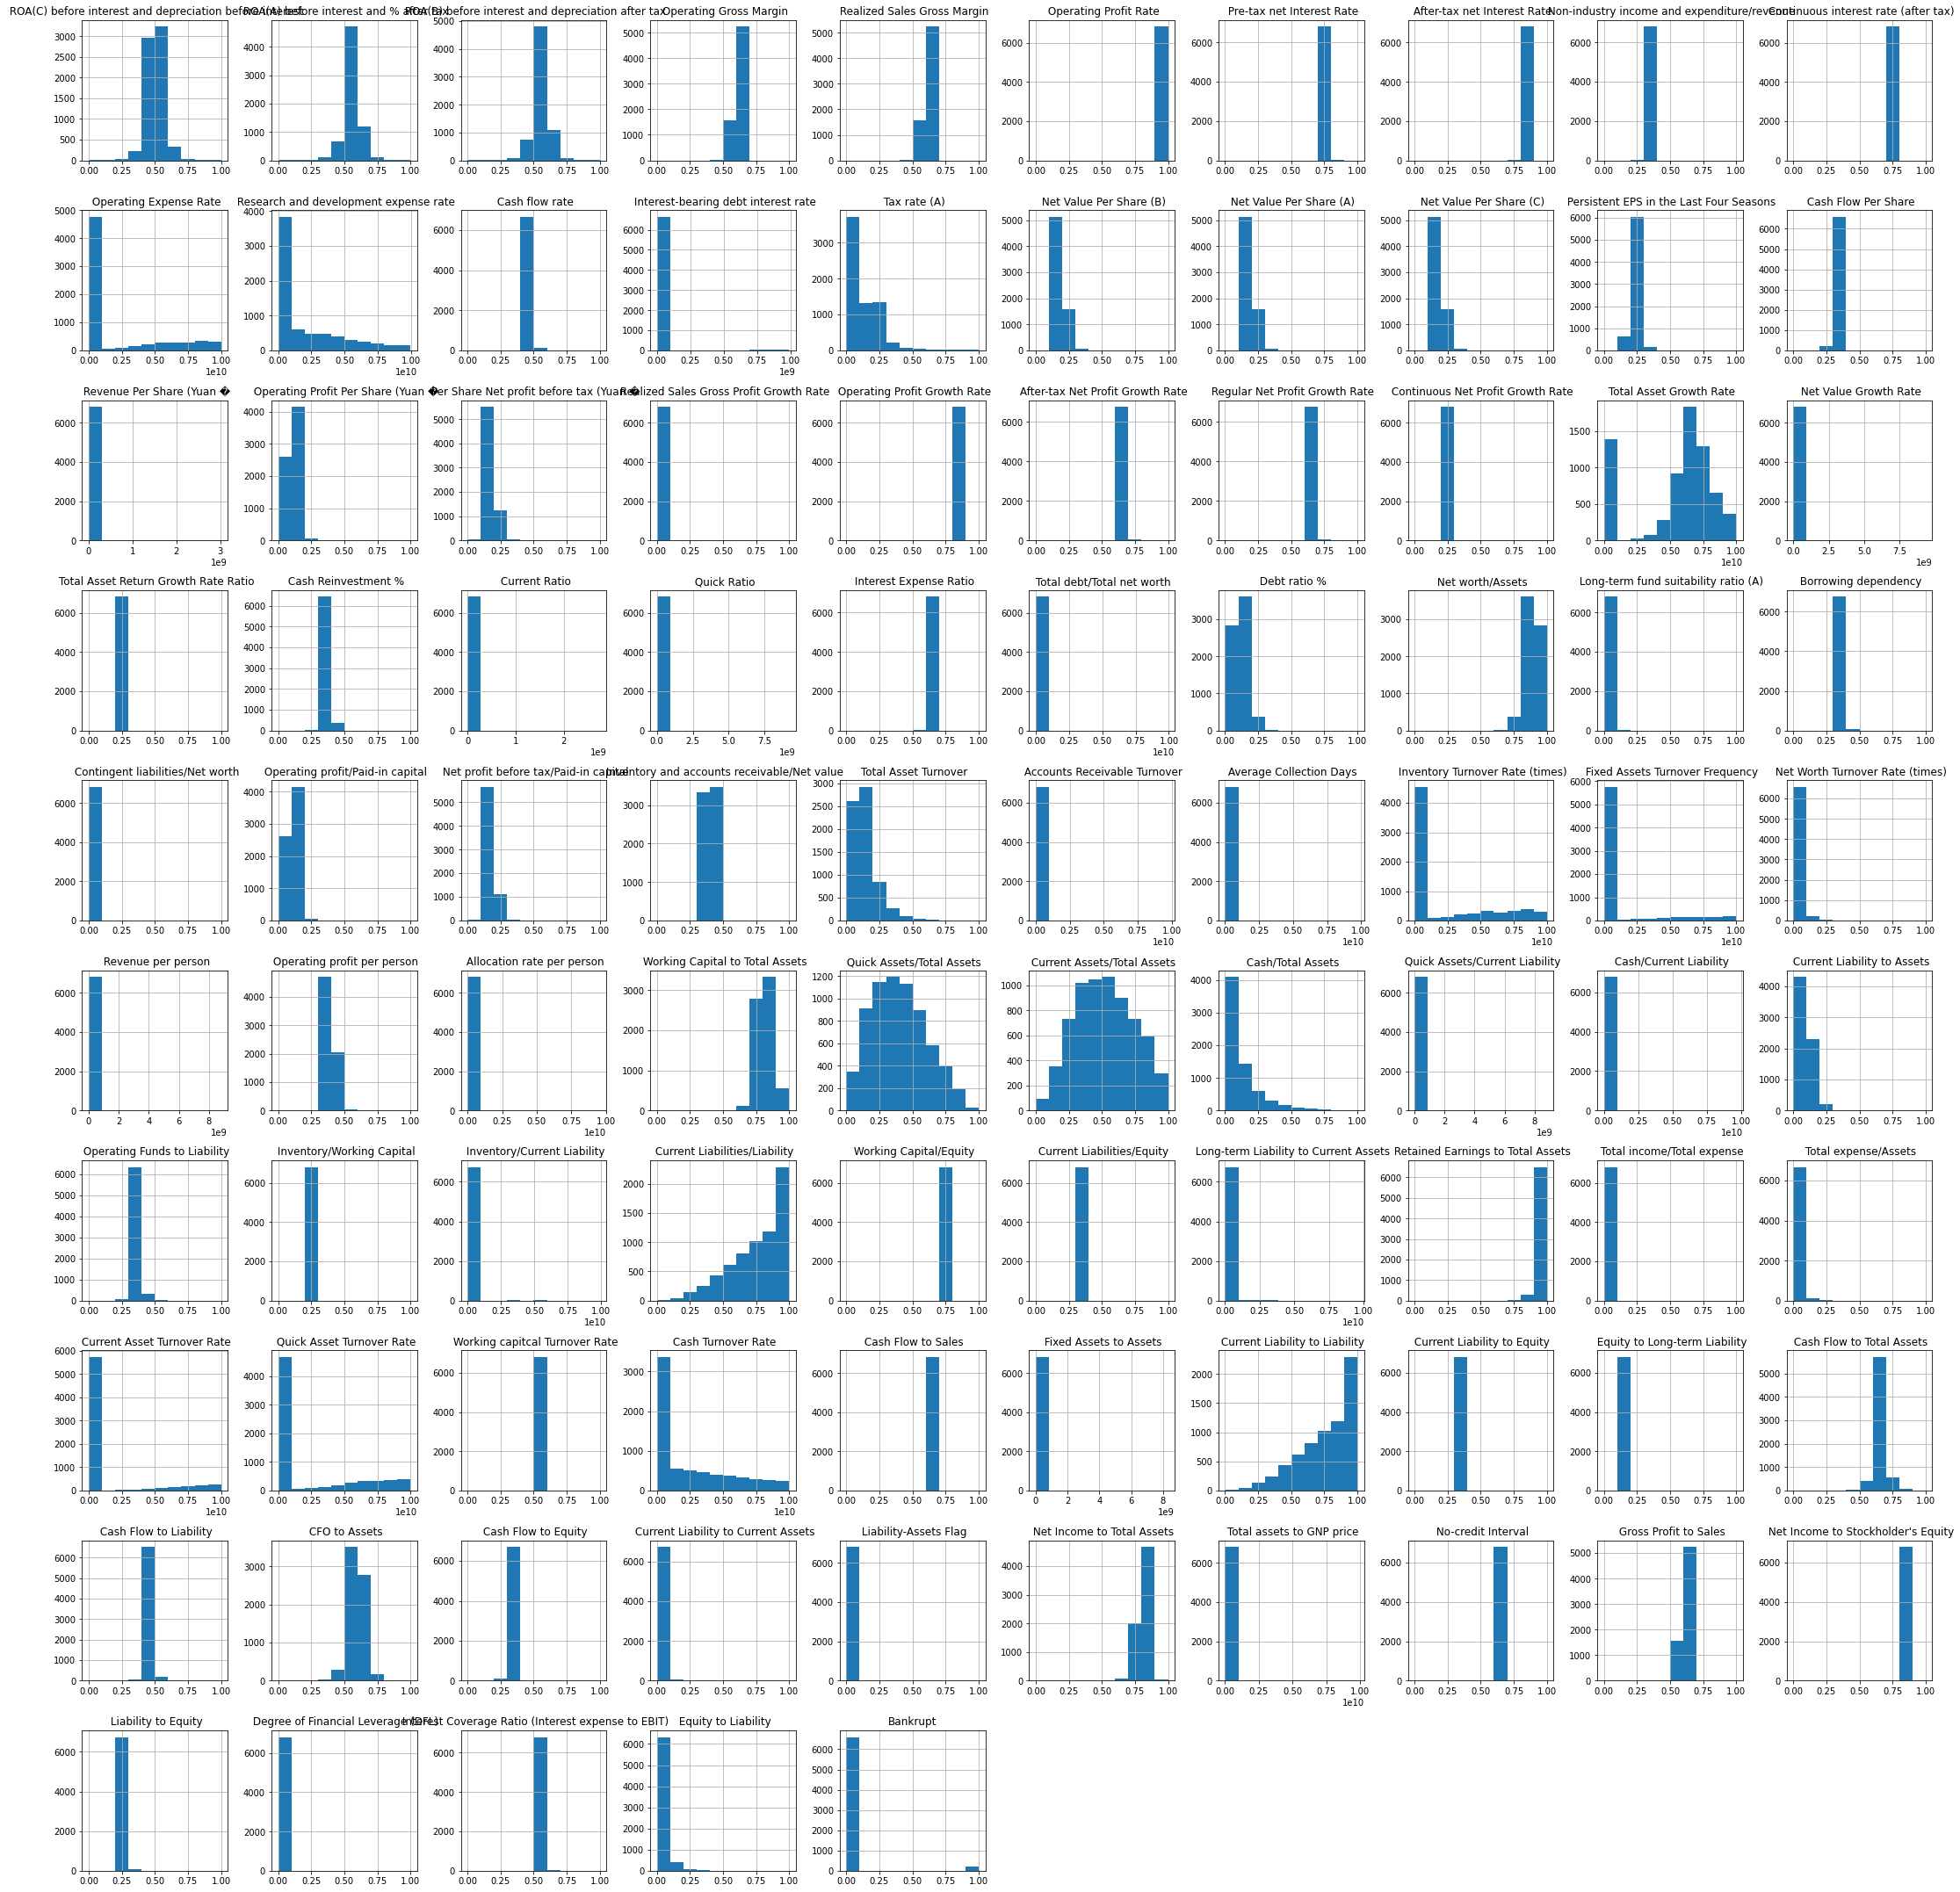

In [250]:
df.hist(figsize=(30, 30))
plt.tight_layout(pad=1)
plt.show()

In [251]:
colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap',
          'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
          'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
          'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
          'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 
          'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu',
           'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 
          'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 
          'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 
          'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 
          'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
          'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 
          'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r',
          'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 
          'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 
          'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 
          'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [252]:
numeric_features = df.dtypes[df.dtypes != 'int64'].index
categorical_features = df.dtypes[df.dtypes == 'int64'].index

df[categorical_features].columns.tolist()

[' Liability-Assets Flag', 'Bankrupt']

In [253]:
positive_corr = df[numeric_features].corrwith(df["Bankrupt"]).sort_values(ascending=False)[:30].index.tolist()
negative_corr = df[numeric_features].corrwith(df["Bankrupt"]).sort_values()[:30].index.tolist()

positive_corr = df[positive_corr + ["Bankrupt"]].copy()
negative_corr = df[negative_corr + ["Bankrupt"]].copy()

In [254]:
def corrbargraph(x_value, y_value):
    
    plt.figure(figsize=(30,35))
    value = randint(0, len(colors)-1)

    for i in range(1,31):
        plt.subplot(10,3,i)  
        sns.barplot(x=x_value, y=y_value[i-1], data=df, palette=colors[value])

    plt.tight_layout(pad=2.5)

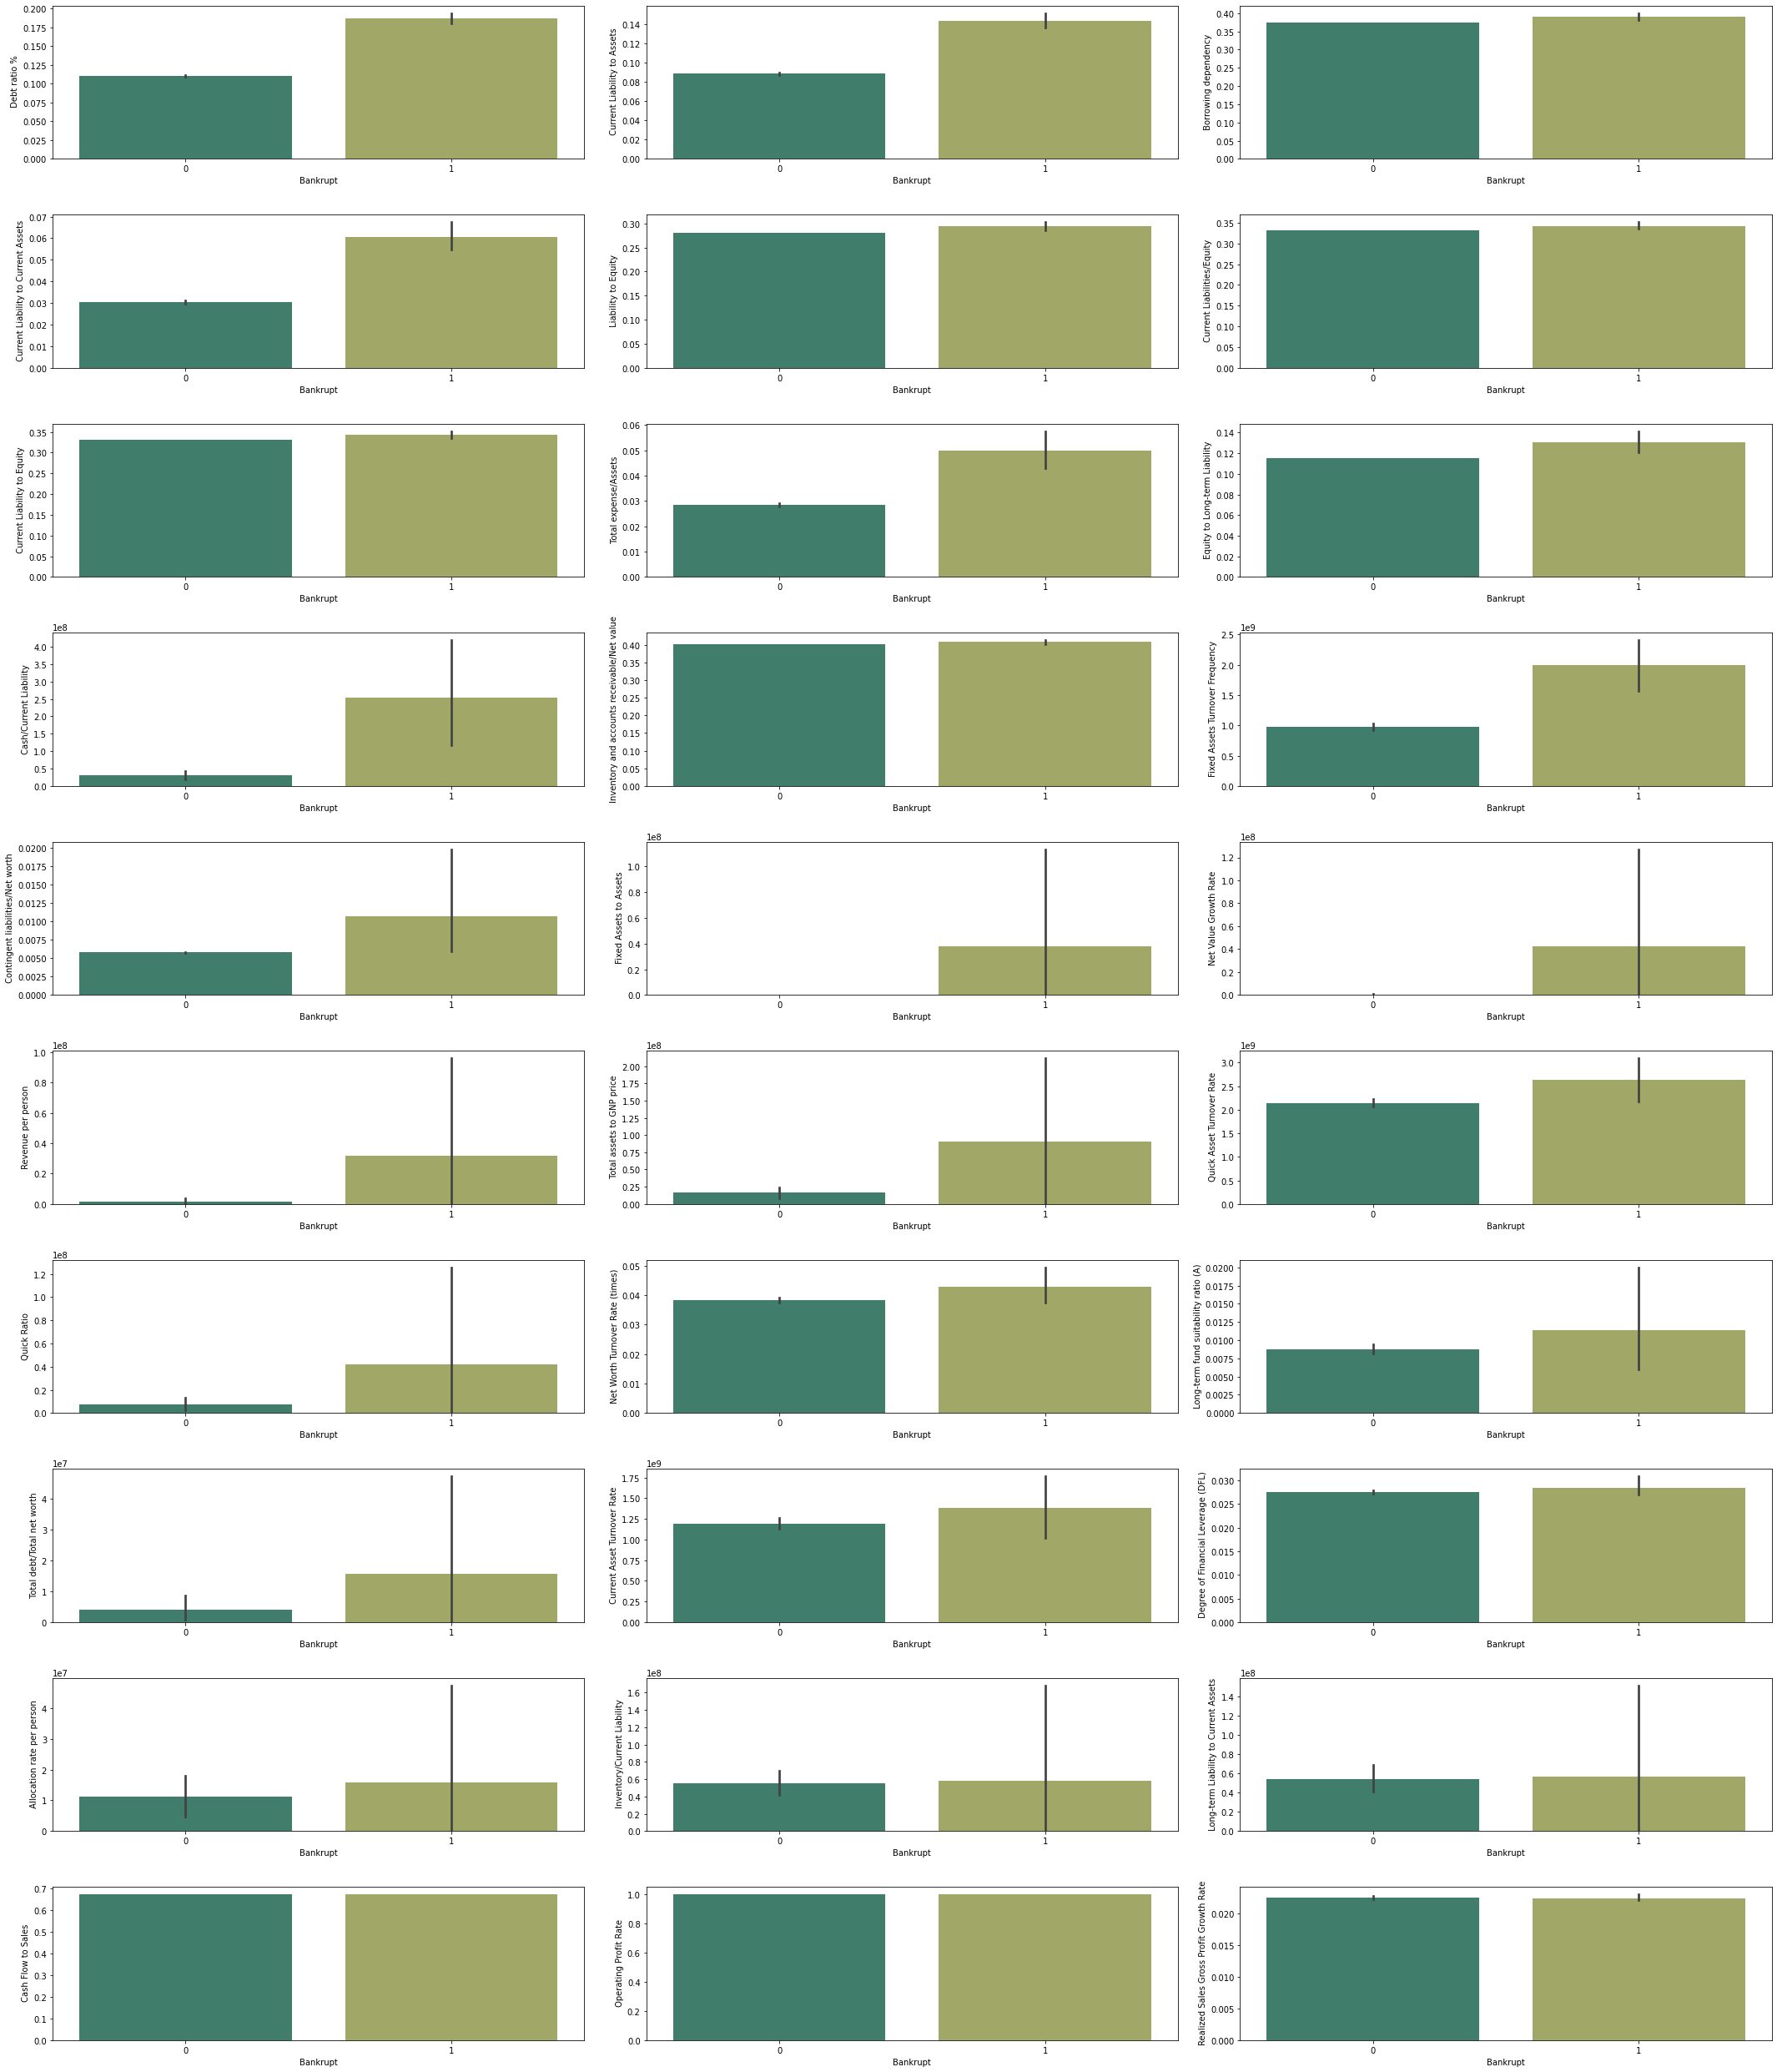

In [255]:
x_value = positive_corr.columns.tolist()[-1]
y_value = positive_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

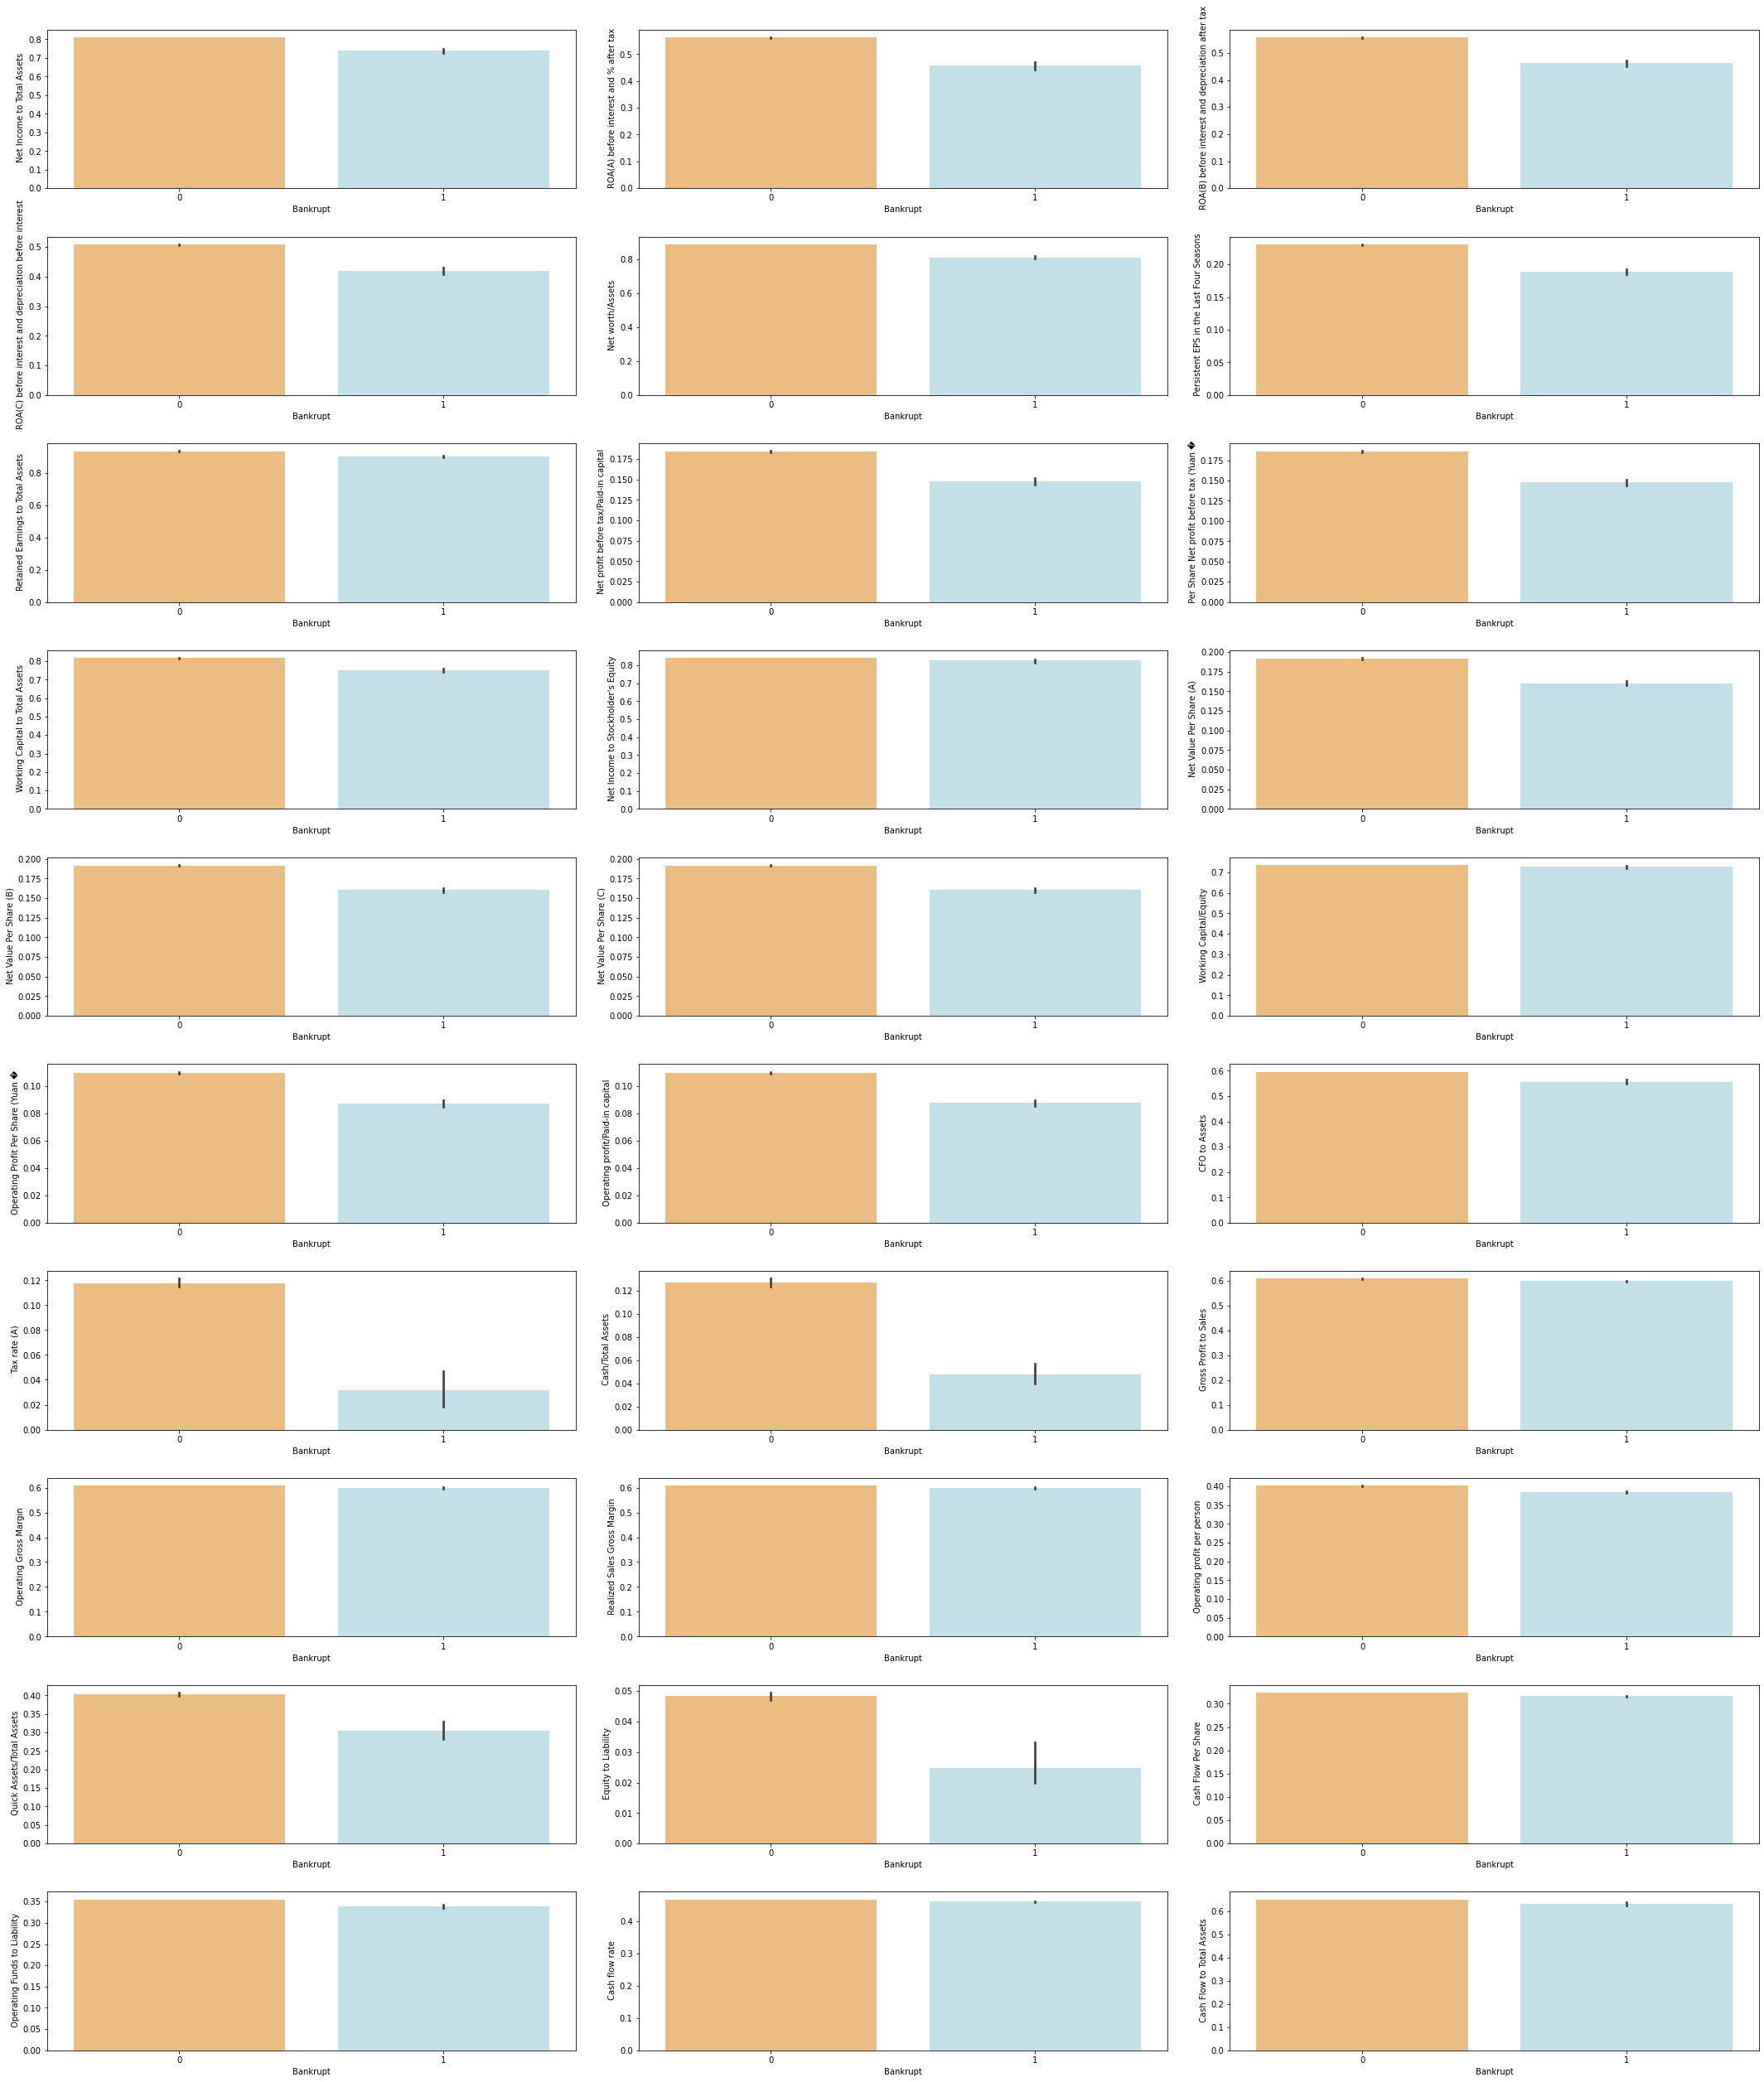

In [256]:
x_value = negative_corr.columns.tolist()[-1]
y_value = negative_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

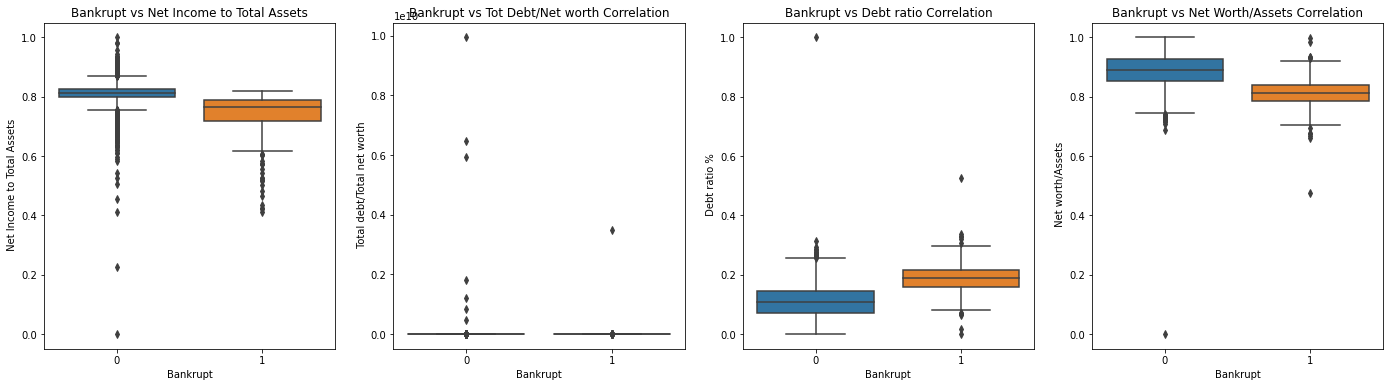

In [257]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y=" Net Income to Total Assets", data=df, ax=axes[0])
axes[0].set_title('Bankrupt vs Net Income to Total Assets')

sns.boxplot(x='Bankrupt', y=" Total debt/Total net worth", data=df, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Tot Debt/Net worth Correlation')

sns.boxplot(x='Bankrupt', y=" Debt ratio %", data=df, ax=axes[2])
axes[2].set_title('Bankrupt vs Debt ratio Correlation')

sns.boxplot(x='Bankrupt', y=" Net worth/Assets", data=df, ax=axes[3])  
axes[3].set_title('Bankrupt vs Net Worth/Assets Correlation') 

plt.show()

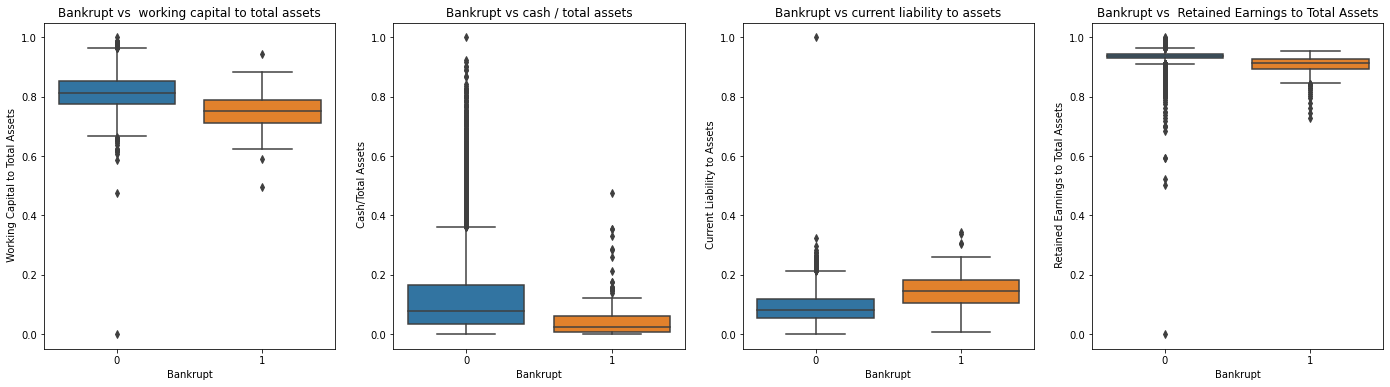

In [258]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y=" Working Capital to Total Assets", data=df, ax=axes[0])
axes[0].set_title('Bankrupt vs  working capital to total assets')

sns.boxplot(x='Bankrupt', y=" Cash/Total Assets", data=df, ax=axes[1])
axes[1].set_title('Bankrupt vs cash / total assets')

sns.boxplot(x='Bankrupt', y=" Current Liability to Assets", data=df, ax=axes[2])
axes[2].set_title('Bankrupt vs current liability to assets')

sns.boxplot(x='Bankrupt', y=" Retained Earnings to Total Assets", data=df, ax=axes[3])
axes[3].set_title('Bankrupt vs  Retained Earnings to Total Assets')

plt.show()

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

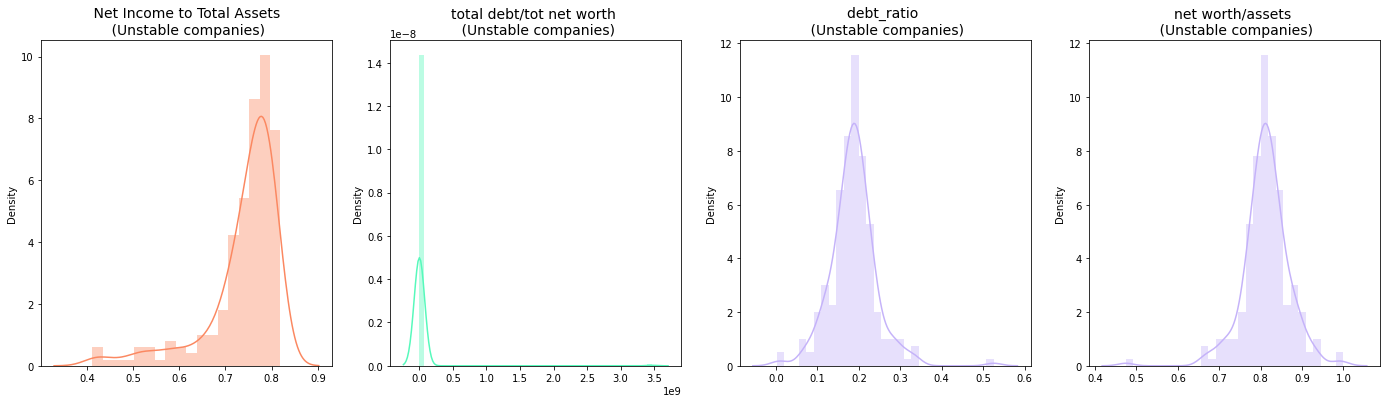

In [259]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = df[' Net Income to Total Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = df[' Total debt/Total net worth'].loc[df['Bankrupt'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = df[' Debt ratio %'].loc[df['Bankrupt'] == 1].values
sns.distplot(debt_ratio,ax=ax3, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = df[' Net worth/Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

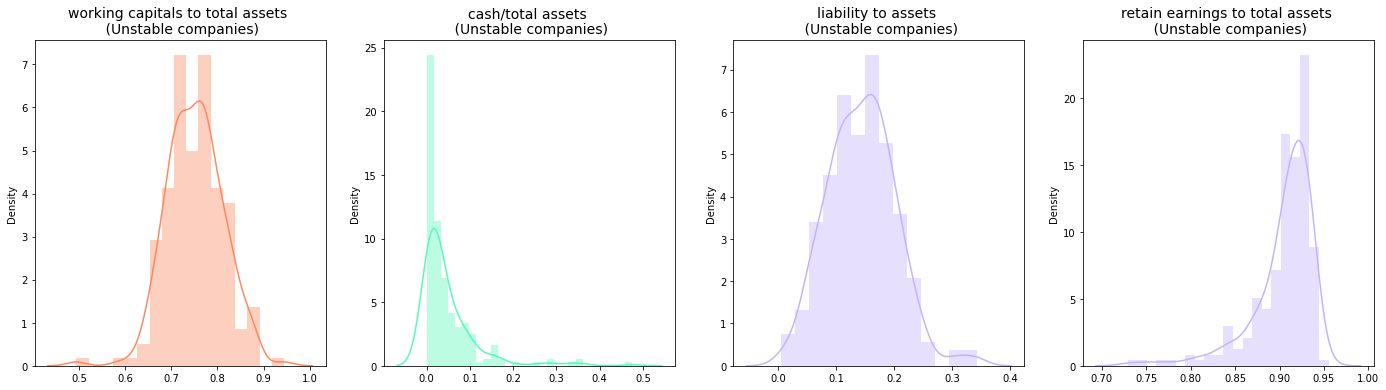

In [260]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = df[' Working Capital to Total Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(working_cap,ax=ax1, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = df[' Cash/Total Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = df[' Current Liability to Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(asset_liab,ax=ax3, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = df[' Retained Earnings to Total Assets'].loc[df['Bankrupt'] == 1].values
sns.distplot(operating_funds,ax=ax4, color='#C5B3F9')
ax4.set_title('retain earnings to total assets \n (Unstable companies)', fontsize=14)

plt.show()

In [261]:
features = [col for col in df.columns if df[col].dtypes in ['int32', 'int64', 'float32', 'float64'] and col not in ['Bankrupt']]

In [262]:
positive_corr = df[features].corrwith(df['Bankrupt']).sort_values(ascending=False)[:10]
positive_corr

 Debt ratio %                           0.250161
 Current Liability to Assets            0.194494
 Borrowing dependency                   0.176543
 Current Liability to Current Assets    0.171306
 Liability to Equity                    0.166812
 Current Liability to Equity            0.153828
 Current Liabilities/Equity             0.153828
 Liability-Assets Flag                  0.139212
 Total expense/Assets                   0.139049
 Equity to Long-term Liability          0.139014
dtype: float64

In [263]:
negative_corr = df[features].corrwith(df['Bankrupt']).sort_values()[:10]
negative_corr

 Net Income to Total Assets                                -0.315457
 ROA(A) before interest and % after tax                    -0.282941
 ROA(B) before interest and depreciation after tax         -0.273051
 ROA(C) before interest and depreciation before interest   -0.260807
 Net worth/Assets                                          -0.250161
 Persistent EPS in the Last Four Seasons                   -0.219560
 Retained Earnings to Total Assets                         -0.217779
 Net profit before tax/Paid-in capital                     -0.207857
 Per Share Net profit before tax (Yuan �                   -0.201395
 Working Capital to Total Assets                           -0.193083
dtype: float64

In [264]:
positive_corr_lst = positive_corr.index.tolist()
positive_corr_lst

[' Debt ratio %',
 ' Current Liability to Assets',
 ' Borrowing dependency',
 ' Current Liability to Current Assets',
 ' Liability to Equity',
 ' Current Liability to Equity',
 ' Current Liabilities/Equity',
 ' Liability-Assets Flag',
 ' Total expense/Assets',
 ' Equity to Long-term Liability']

In [265]:
negative_corr_lst = negative_corr.index.tolist()
negative_corr_lst

[' Net Income to Total Assets',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' Persistent EPS in the Last Four Seasons',
 ' Retained Earnings to Total Assets',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan �',
 ' Working Capital to Total Assets']

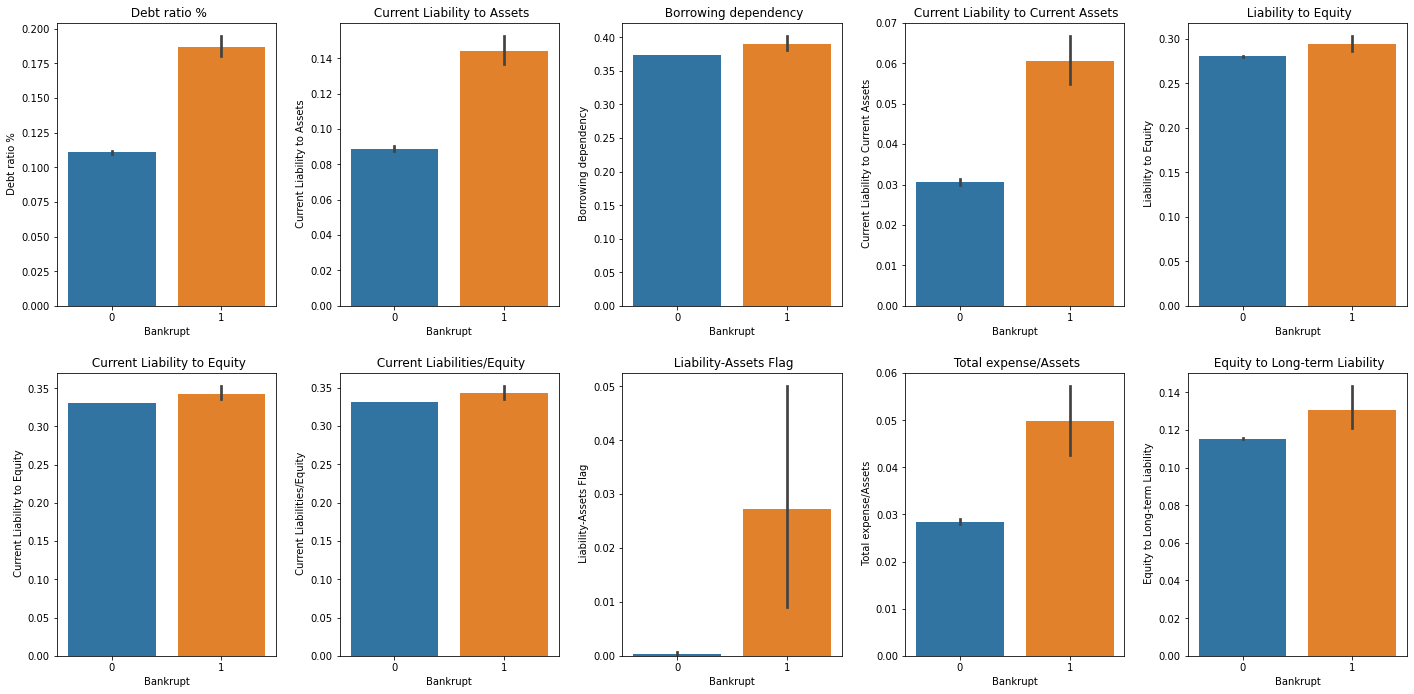

In [266]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(positive_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.barplot(data=df, x='Bankrupt', y=col)
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

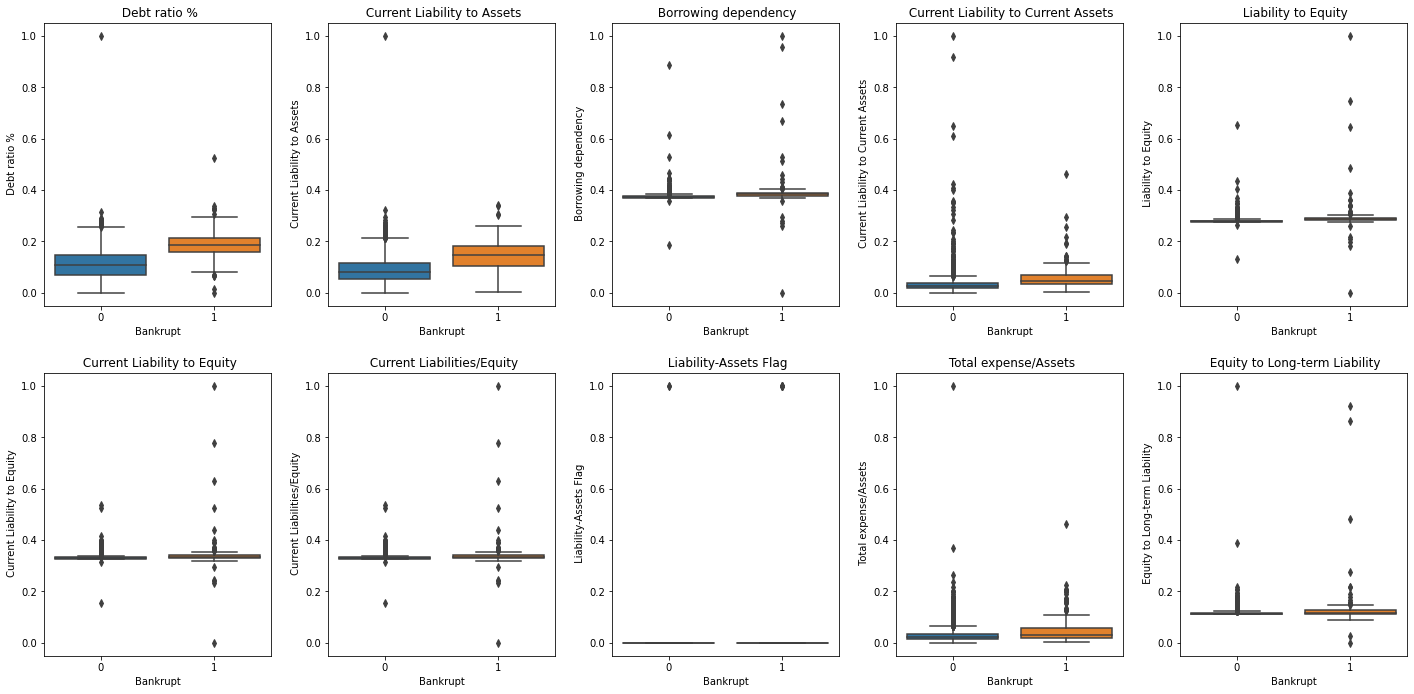

In [267]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(positive_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data=df, x='Bankrupt', y=col)
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

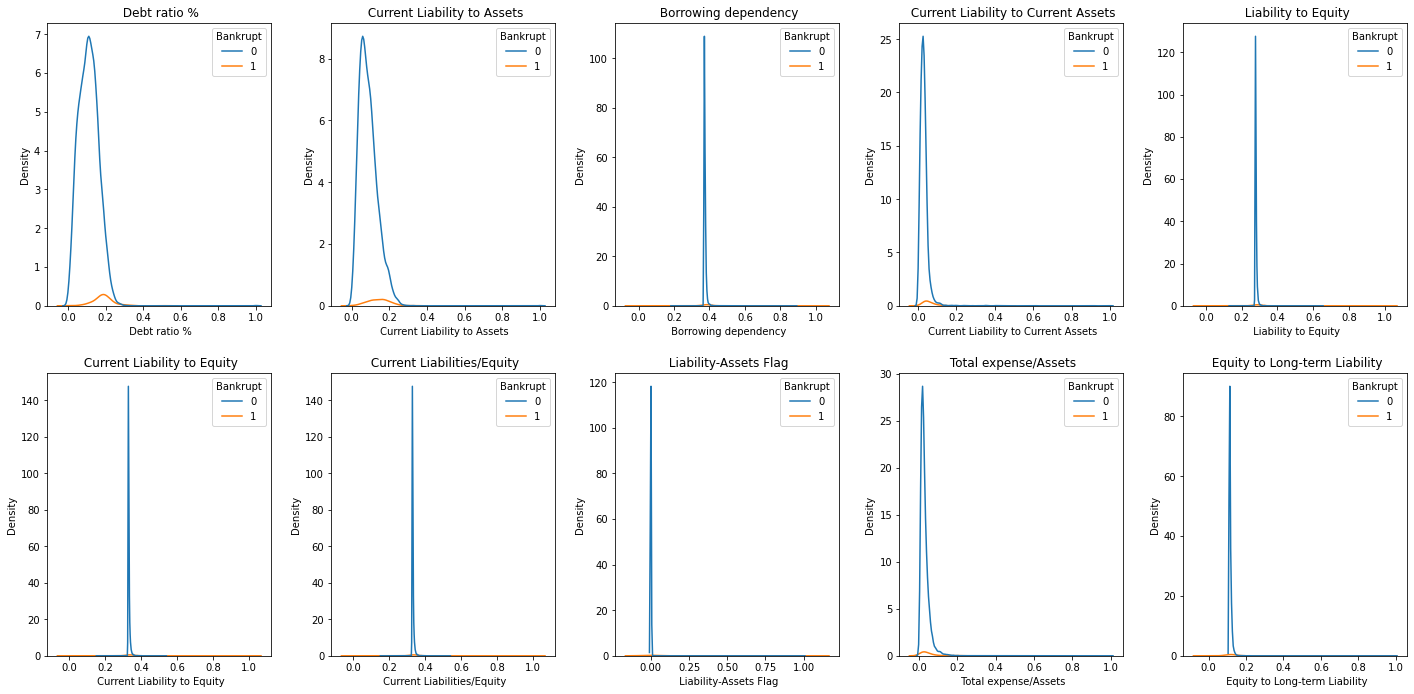

In [268]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(positive_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(data=df, x=col, hue='Bankrupt')
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

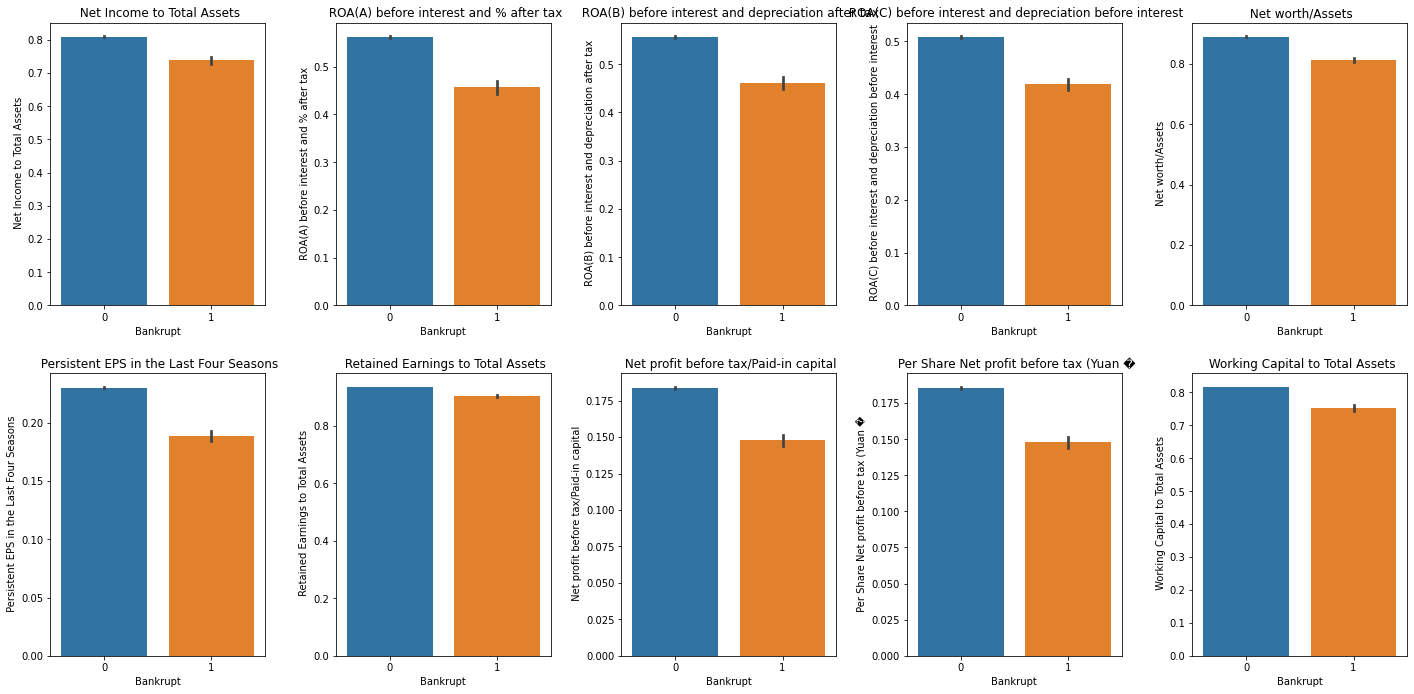

In [269]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(negative_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.barplot(data=df, x='Bankrupt', y=col)
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

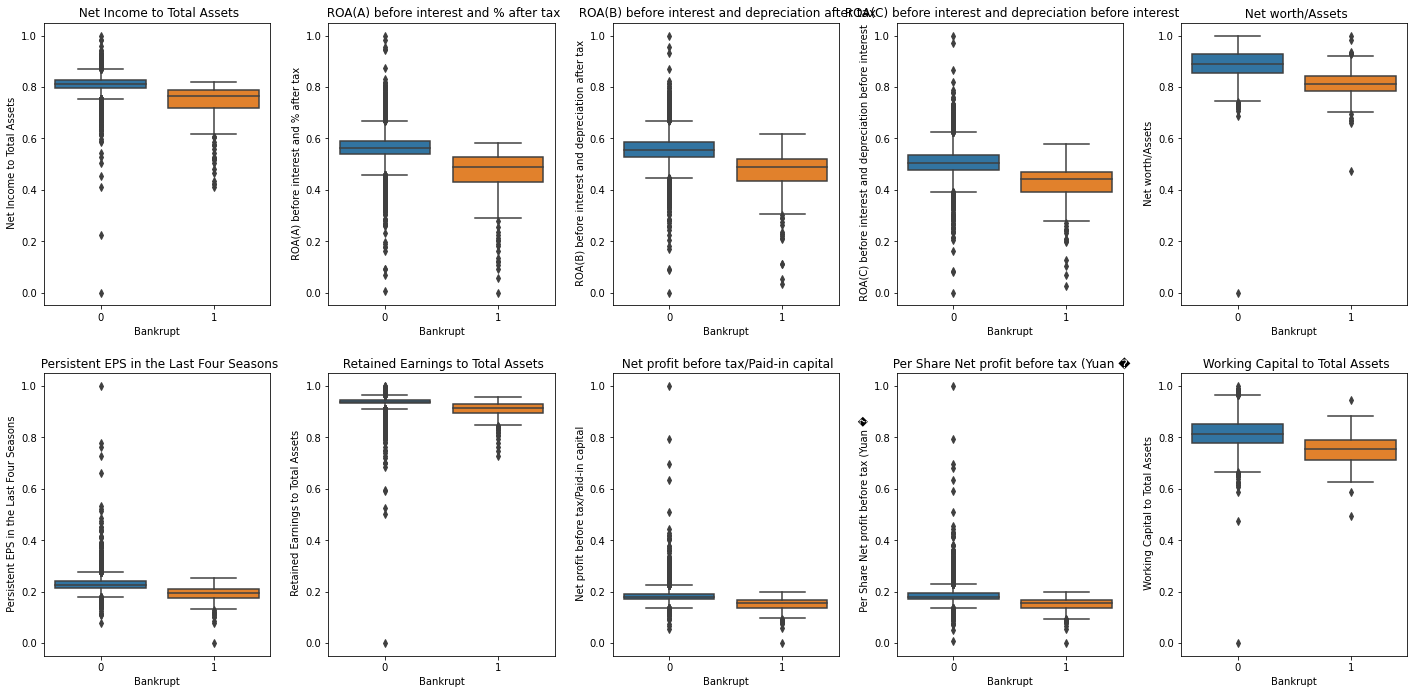

In [270]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(negative_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data=df, x='Bankrupt', y=col)
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

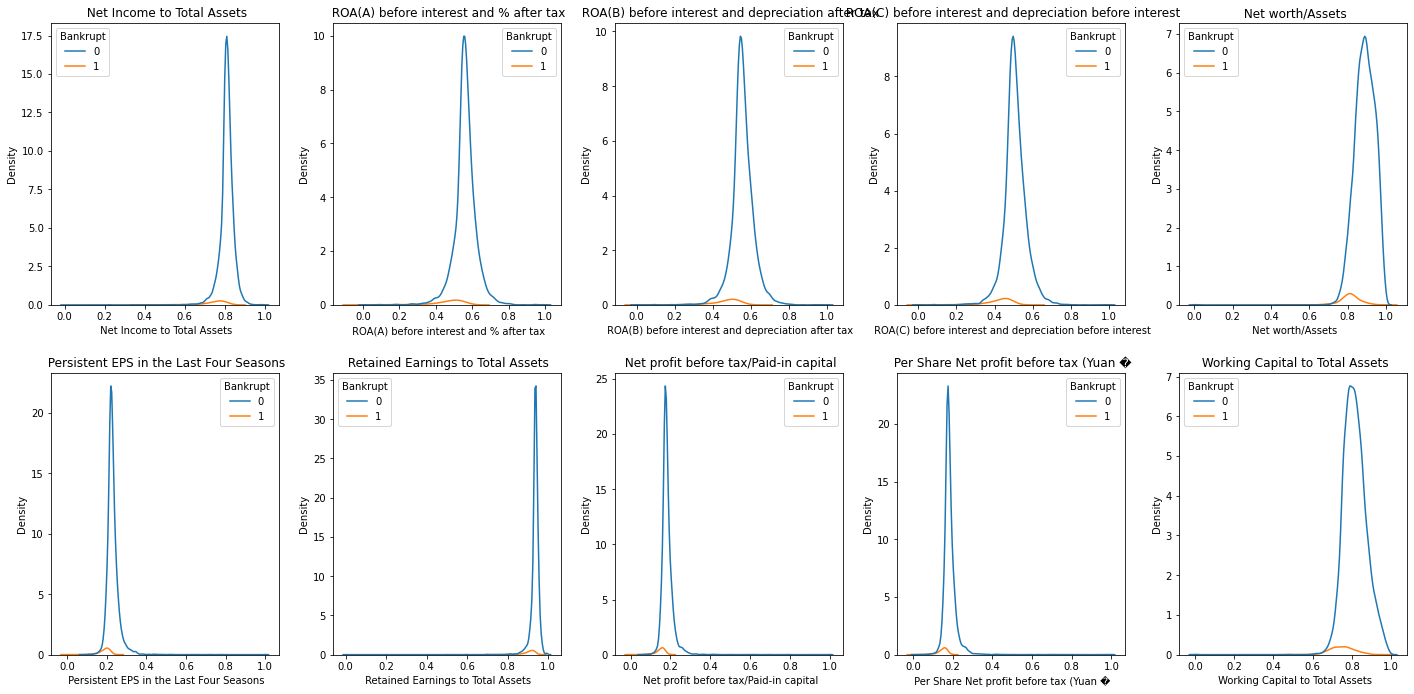

In [271]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(negative_corr_lst):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(data=df, x=col, hue='Bankrupt')
    plt.title(col)
    plt.tight_layout(pad=2)
plt.show()

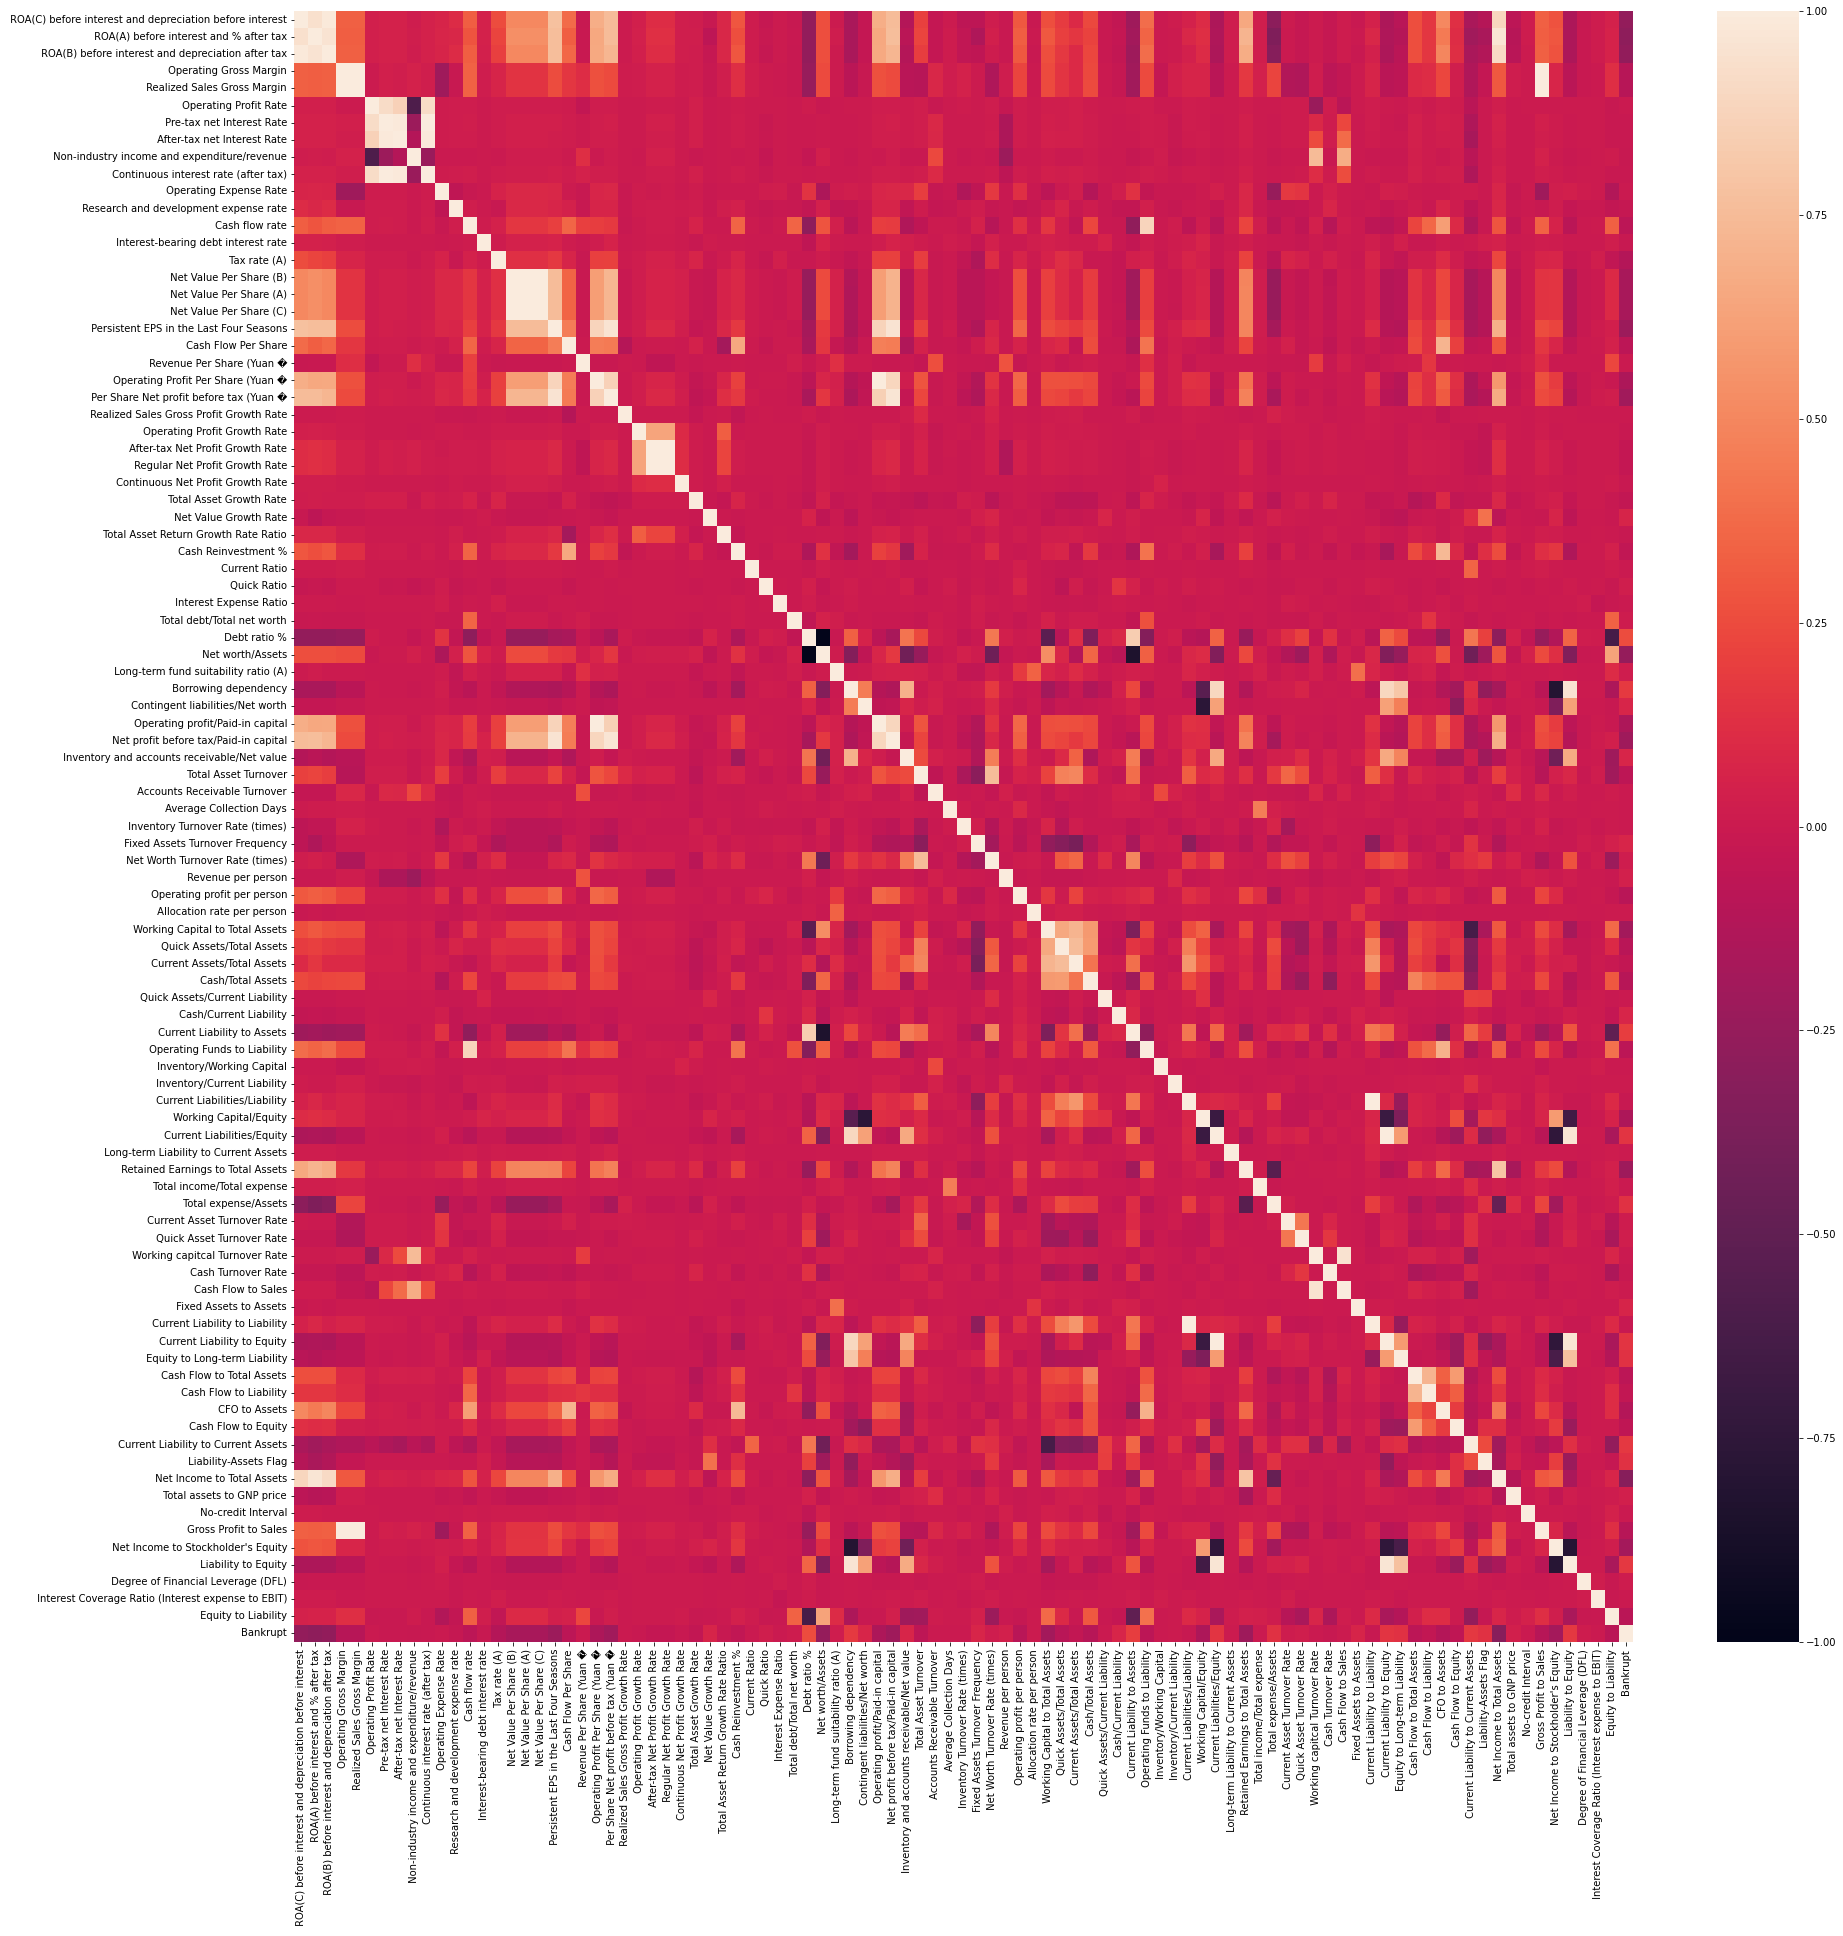

In [272]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr())
plt.show()

In [273]:
X = df.drop('Bankrupt', axis=1)
y = df['Bankrupt']
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Bankrupt   No. Observations:                 6819
Model:                            GLM   Df Residuals:                     6762
Model Family:                Binomial   Df Model:                           56
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 23 Apr 2023   Deviance:                       20907.
Time:                        01:29:25   Pearson chi2:                 1.02e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


In [274]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 95))

Top Absolute Correlations
 Current Liabilities/Liability                       Current Liability to Liability        1.000000
 Current Liabilities/Equity                          Current Liability to Equity           1.000000
 Debt ratio %                                        Net worth/Assets                      1.000000
 Operating Gross Margin                              Gross Profit to Sales                 1.000000
 Net Value Per Share (A)                             Net Value Per Share (C)               0.999837
                                                                                             ...   
 ROA(B) before interest and depreciation after tax   Operating profit/Paid-in capital      0.657274
 ROA(A) before interest and % after tax              Operating Profit Per Share (Yuan �    0.654253
                                                     Operating profit/Paid-in capital      0.651581
 Working Capital/Equity                              Liability to Equity  

In [275]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
to_drop

[' Continuous interest rate (after tax)',
 ' Per Share Net profit before tax (Yuan �',
 ' Operating profit/Paid-in capital',
 ' Net profit before tax/Paid-in capital',
 ' Current Liability to Liability',
 ' Current Liability to Equity',
 ' Net Income to Total Assets',
 ' Gross Profit to Sales',
 ' Liability to Equity']

In [276]:
df.drop(to_drop, axis=1, inplace=True)

In [277]:
X = df.drop('Bankrupt', axis=1)
X_mean = X.mean(axis=0)
var = np.var(X/X_mean)
var_ = var.sort_values(ascending=False).head(30)
var_

 Current Ratio                            6817.999489
 Fixed Assets to Assets                   6817.997213
 Net Value Growth Rate                    5312.004777
 Revenue per person                       3450.486394
 Quick Assets/Current Liability           2281.318433
 Revenue Per Share (Yuan �                1514.333244
 Total debt/Total net worth               1453.890641
 Quick Ratio                               853.129754
 Liability-Assets Flag                     851.375000
 Allocation rate per person                684.500651
 Average Collection Days                   680.550015
 Accounts Receivable Turnover              473.277969
 Total assets to GNP price                 408.274712
 Cash/Current Liability                    188.591801
 Long-term Liability to Current Assets     110.851196
 Inventory/Current Liability               108.763933
 Interest-bearing debt interest rate        43.327745
 Total income/Total expense                 22.504532
 Long-term fund suitability 

In [278]:
cols = [' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan �', 
                ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
                ' Total debt/Total net worth', ' Accounts Receivable Turnover', 
                ' Average Collection Days', ' Revenue per person', 
                ' Allocation rate per person', ' Quick Assets/Current Liability', 
                ' Cash/Current Liability', ' Inventory/Current Liability', 
                ' Long-term Liability to Current Assets',
                ' Fixed Assets to Assets', ' Total assets to GNP price']

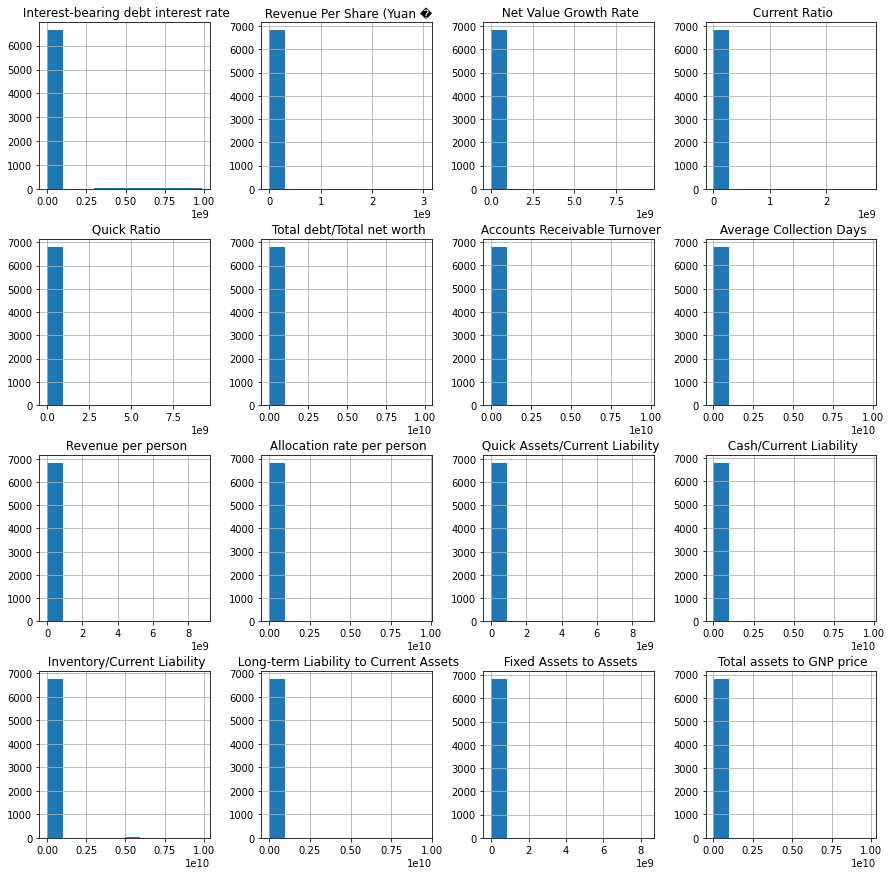

In [279]:
df[cols].hist(figsize=(15, 15))
plt.show()

In [280]:
for col in cols:
    df.loc[:, col] = winsorize(df[col], limits=(0.0, 0.05))

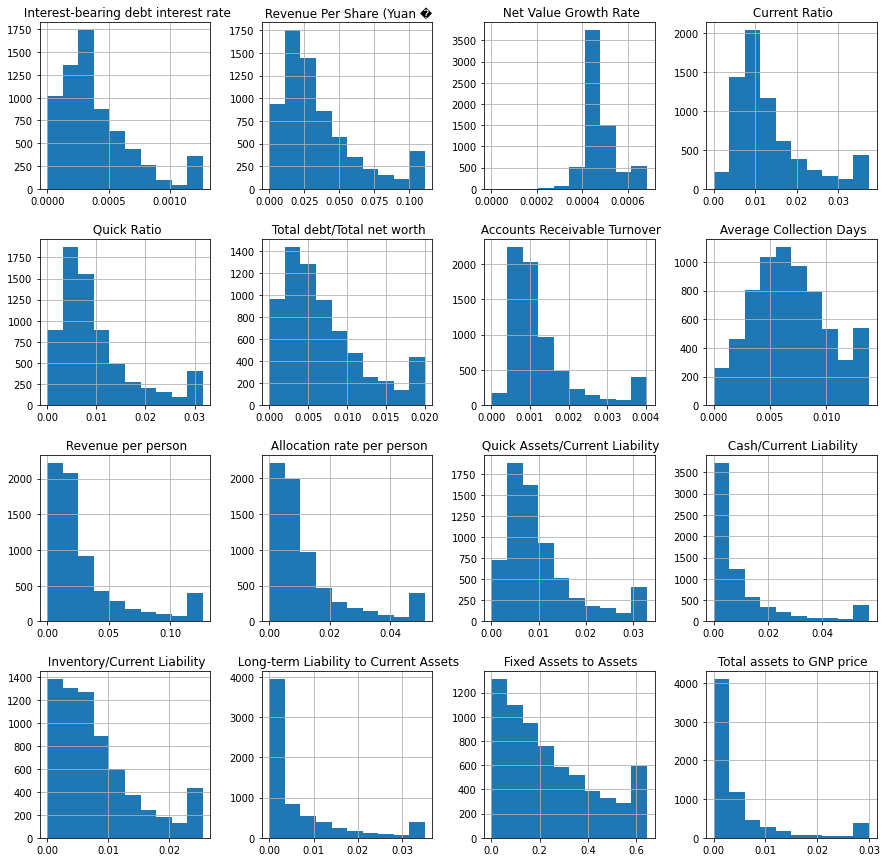

In [281]:
df[cols].hist(figsize=(15, 15))
plt.show()

In [282]:
def remove_multicollinearity(data, target, vif_threshold=10):
    def calculate_vif(X, col):
        if col != target:
            vif = pd.DataFrame()
            vif["features"] = X.columns
            vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            vif = vif.sort_values(ascending=False, by='VIF')
            return vif

    features = data.select_dtypes(include=np.number)
    dropped_columns = []
    for col in features.columns:
        vif = calculate_vif(features, col)
        if vif is not None and vif["VIF"].max() > vif_threshold:
            remove_feature = vif.loc[vif["VIF"].idxmax()]["features"]
            data.drop(columns=[remove_feature], axis=1, inplace=True)
            dropped_columns.append(remove_feature)
            features = data.select_dtypes(include=np.number)
    return data, dropped_columns

In [283]:
target = "Bankrupt"
df_copy, dropped_cols = remove_multicollinearity(df, target)

In [284]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_copy))

Top Absolute Correlations
 Cash/Total Assets               Cash/Current Liability                   0.782618
 Total Asset Turnover            Net Worth Turnover Rate (times)          0.757414
 Cash Reinvestment %             CFO to Assets                            0.738276
 Operating Funds to Liability    CFO to Assets                            0.702937
 Current Liabilities/Liability   Long-term Liability to Current Assets    0.647707
dtype: float64


In [285]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

def scale_column(df, col_name, target):
    for col in col_name:
        if col != target:
            skewness = df[col].skew()
            if skewness > 1:
                df.loc[:, col] = np.log1p(df[col])
            elif skewness < -1:
                scaler = PowerTransformer(standardize=False)
                df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        else:
            continue
            
    return df

In [286]:
cols = [col for col in df_copy.columns if df_copy[col].dtypes in ['int64', 'float64'] and col not in ['Bankrupt']]
cols

[' After-tax net Interest Rate',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Realized Sales Gross Profit Growth Rate',
 ' Total Asset Growth Rate',
 ' Cash Reinvestment %',
 ' Interest Expense Ratio',
 ' Total debt/Total net worth',
 ' Long-term fund suitability ratio (A)',
 ' Contingent liabilities/Net worth',
 ' Total Asset Turnover',
 ' Accounts Receivable Turnover',
 ' Inventory Turnover Rate (times)',
 ' Fixed Assets Turnover Frequency',
 ' Net Worth Turnover Rate (times)',
 ' Revenue per person',
 ' Allocation rate per person',
 ' Cash/Total Assets',
 ' Cash/Current Liability',
 ' Operating Funds to Liability',
 ' Inventory/Current Liability',
 ' Current Liabilities/Liability',
 ' Long-term Liability to Current Assets',
 ' Total income/Total expense',
 ' Total expense/Assets',
 ' Current Asset Turnover Rate',
 ' Quick Asset Turnover Rate',
 ' Cash Turnover Rate',
 ' Fixed Assets to Assets',
 

In [287]:
scaled_df = scale_column(df_copy, cols, 'Bankrupt')
scaled_df

,After-tax net Interest Rate,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Realized Sales Gross Profit Growth Rate,Total Asset Growth Rate,Cash Reinvestment %,Interest Expense Ratio,Total debt/Total net worth,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Total Asset Turnover,Accounts Receivable Turnover,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Operating Funds to Liability,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Equity to Long-term Liability,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
0,47.505464,0.000126,0.000000,0.000725,0.000000,0.021862,4.980000e+09,0.310220,1.013835,0.019772,0.005012,0.006458,0.083382,0.001812,0.000182,0.000116,0.032374,0.033594,0.036462,0.004086,0.000147,0.288193,0.001035,0.676269,0.025270,0.002020,0.062839,20.368018,22.602731,4.580000e+08,0.424206,0.119159,0.520382,0.111765,0.0,0.009177,95.581883,0.026253,0.960369,0.016335,1
1,47.641184,0.000290,0.000000,0.000647,0.000000,0.021840,6.110000e+09,0.319696,1.025829,0.012425,0.005046,0.005818,0.062475,0.001286,22.959711,20.393372,0.025165,0.006865,0.012260,0.014837,0.001383,0.293495,0.005196,0.308589,0.023665,0.002223,0.025196,0.000107,22.764486,2.490000e+09,0.468828,0.114146,0.567101,0.046669,0.0,0.008289,103.197661,0.234738,0.975897,0.020581,1
2,47.389227,0.000236,17.054189,0.000790,0.000000,0.022505,7.280000e+09,0.314017,1.013103,0.019772,0.005087,0.006541,0.014881,0.001494,17.989898,21.697825,0.013298,0.028585,0.050220,0.000990,0.055458,0.290227,0.013783,0.446027,0.003708,0.002058,0.021162,0.001789,0.001022,7.610000e+08,0.276179,0.111472,0.538491,0.025031,0.0,0.029451,101.131140,0.026208,0.959501,0.016340,1
3,47.548581,0.000108,0.000000,0.000449,0.000000,0.021807,4.880000e+09,0.325033,1.014470,0.009527,0.005034,0.005352,0.086136,0.001964,22.687577,22.937020,0.027678,0.015345,0.021096,0.018675,0.001010,0.299153,0.003534,0.615848,0.021923,0.001830,0.023874,22.820056,22.523324,2.030000e+09,0.559144,0.114007,0.604105,0.065085,0.0,0.003247,99.807940,0.026346,0.961919,0.023699,1
4,47.642012,22.788862,0.000000,0.000686,0.000000,0.021855,5.510000e+09,0.321859,1.027863,0.005136,0.005289,0.006602,0.161619,0.001448,0.000163,0.000293,0.039376,0.056486,0.023705,0.014062,0.000680,0.296125,0.004857,0.975007,0.000000,0.002221,0.026043,22.622384,22.342654,8.240000e+08,0.309555,0.105200,0.578469,0.046622,0.0,0.003870,103.199931,0.024450,0.989798,0.034875,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,47.649575,0.000151,22.227343,0.000179,0.107393,0.022127,7.070000e+09,0.322196,1.017191,0.006633,0.005137,0.005352,0.098440,0.000690,17.511862,0.000143,0.027521,0.006328,0.006293,0.094838,0.005059,0.297304,0.013125,0.786888,0.001791,0.002263,0.018880,0.000229,0.000124,1.077940e-04,0.400338,0.106719,0.587178,0.027567,0.0,0.000465,103.452337,0.026705,0.965788,0.029452,0
6815,47.648530,22.375763,21.087909,0.000237,0.315975,0.021917,5.220000e+09,0.320190,1.017361,0.004613,0.006749,0.008582,0.098440,0.000655,23.019833,0.000605,0.027050,0.015955,0.003395,0.077273,0.004716,0.294285,0.006708,0.849898,0.002202,0.002286,0.011057,0.000152,0.000117,7.710000e+09,0.096136,0.106456,0.569498,0.030985,0.0,0.001957,103.417522,0.026650,0.965345,0.037569,0
6816,47.645649,0.000251,0.000104,0.000000,0.399339,0.021828,5.990000e+09,0.321643,1.015350,0.00

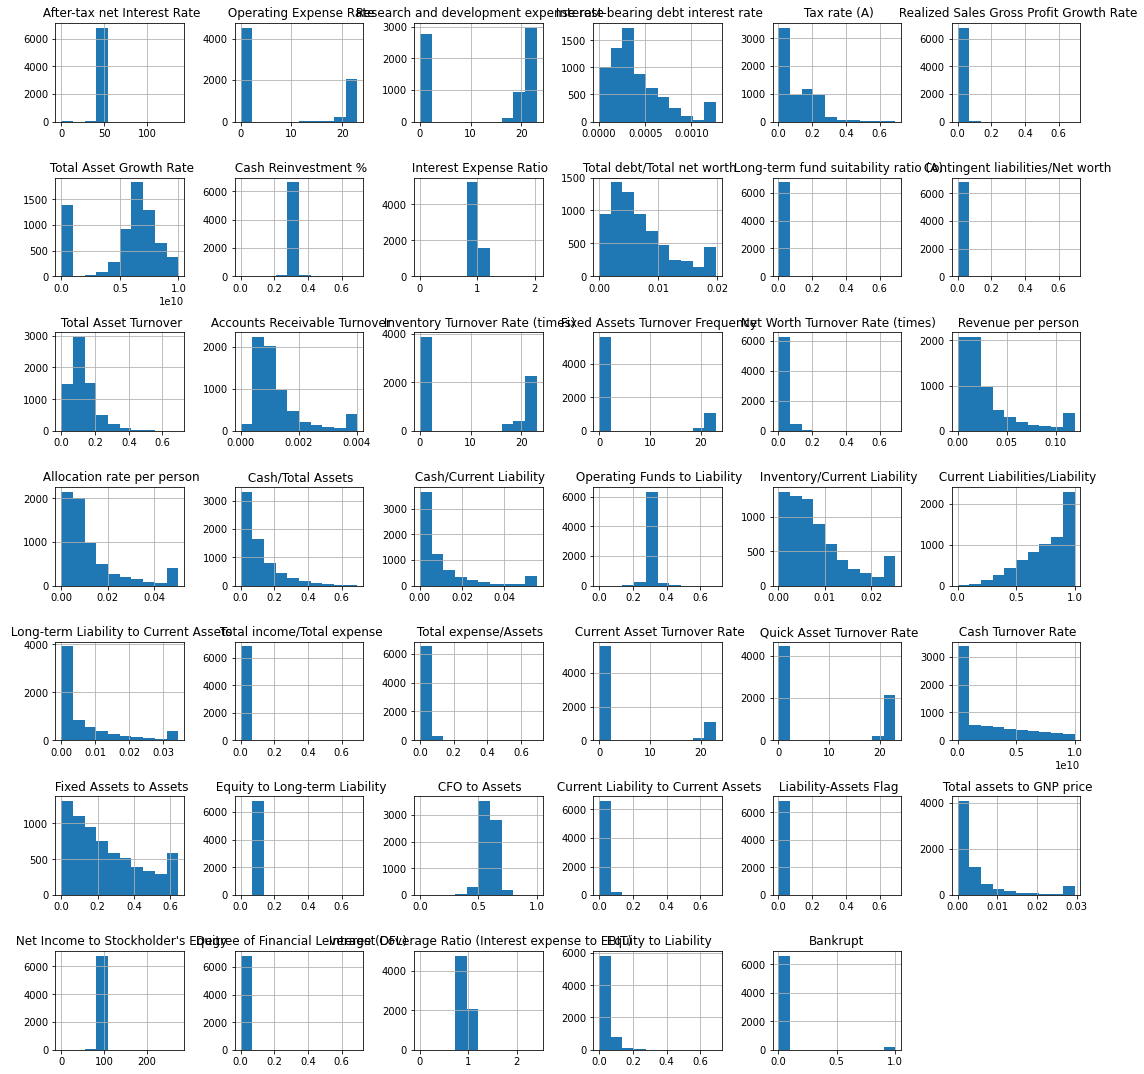

In [288]:
df.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

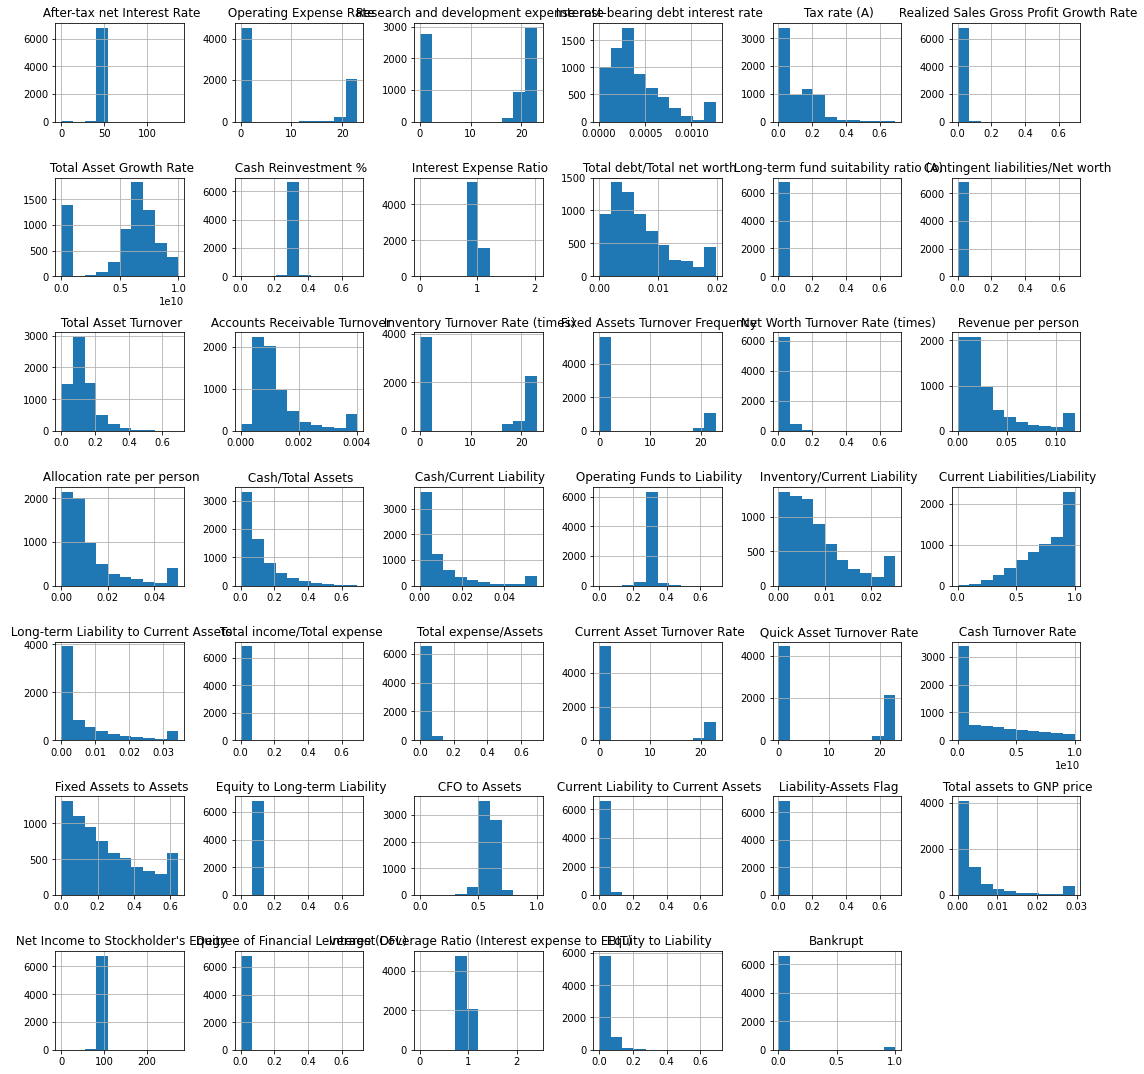

In [289]:
scaled_df.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

In [290]:
scaled_df.drop(' Liability-Assets Flag', axis=1, inplace=True)

In [291]:
X = scaled_df.drop('Bankrupt', axis=1)
X_mean = X.mean(axis=0)
var = np.var(X/X_mean)
var_ = var.sort_values(ascending=False)
var_

 Total income/Total expense                            11.231328
 Long-term fund suitability ratio (A)                   6.515348
 Fixed Assets Turnover Frequency                        4.558284
 Current Asset Turnover Rate                            4.535133
 Long-term Liability to Current Assets                  2.176772
 Total assets to GNP price                              2.104463
 Contingent liabilities/Net worth                       2.085056
 Operating Expense Rate                                 1.993969
 Quick Asset Turnover Rate                              1.865797
 Cash/Current Liability                                 1.747663
 Cash Turnover Rate                                     1.412978
 Inventory Turnover Rate (times)                        1.329222
 Tax rate (A)                                           1.261177
 Allocation rate per person                             1.072546
 Cash/Total Assets                                      1.018076
 Revenue per person      

In [329]:
X = scaled_df.drop('Bankrupt', axis=1)
y = scaled_df['Bankrupt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [293]:
model = RandomForestClassifier(random_state=1, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [294]:
important_features = model.feature_importances_
feature_importance = pd.Series(important_features, index=X.columns)
feature_importance = feature_importance.reset_index(name='Values')
feature_importance

,index,Values
0,After-tax net Interest Rate,0.095793
1,Operating Expense Rate,0.007436
2,Research and development expense rate,0.006519
3,Interest-bearing debt interest rate,0.019101
4,Tax rate (A),0.017545
5,Realized Sales Gross Profit Growth Rate,0.010852
6,Total Asset Growth Rate,0.018202
7,Cash Reinvestment %,0.008564
8,Interest Expense Ratio,0.046551
9,Total debt/Total net worth,0.105300


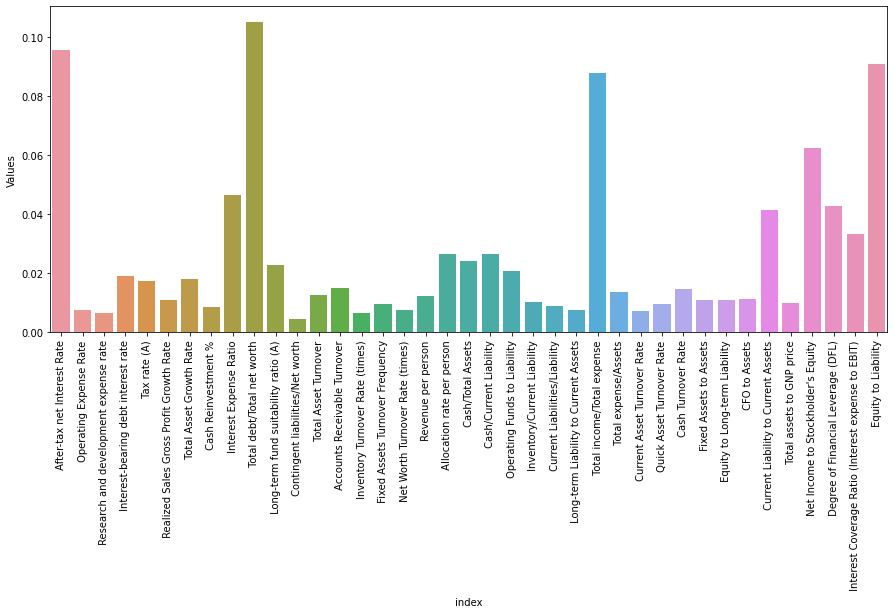

In [295]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importance, x='index', y='Values')
plt.xticks(rotation=90)
plt.show()

In [296]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = scaled_df.drop('Bankrupt', axis=1)
y = scaled_df['Bankrupt']
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)
mi_scores

 Net Income to Stockholder's Equity                    0.038962
 Interest Expense Ratio                                0.034694
 Equity to Liability                                   0.034321
 Interest Coverage Ratio (Interest expense to EBIT)    0.034157
 Degree of Financial Leverage (DFL)                    0.034007
 Total income/Total expense                            0.030824
 Total debt/Total net worth                            0.029503
 After-tax net Interest Rate                           0.028872
 Current Liability to Current Assets                   0.022978
 Cash/Current Liability                                0.021477
 Tax rate (A)                                          0.018545
 Cash/Total Assets                                     0.015370
 Operating Funds to Liability                          0.015306
 Total Asset Growth Rate                               0.010694
 Long-term fund suitability ratio (A)                  0.010320
 Interest-bearing debt interest rate    

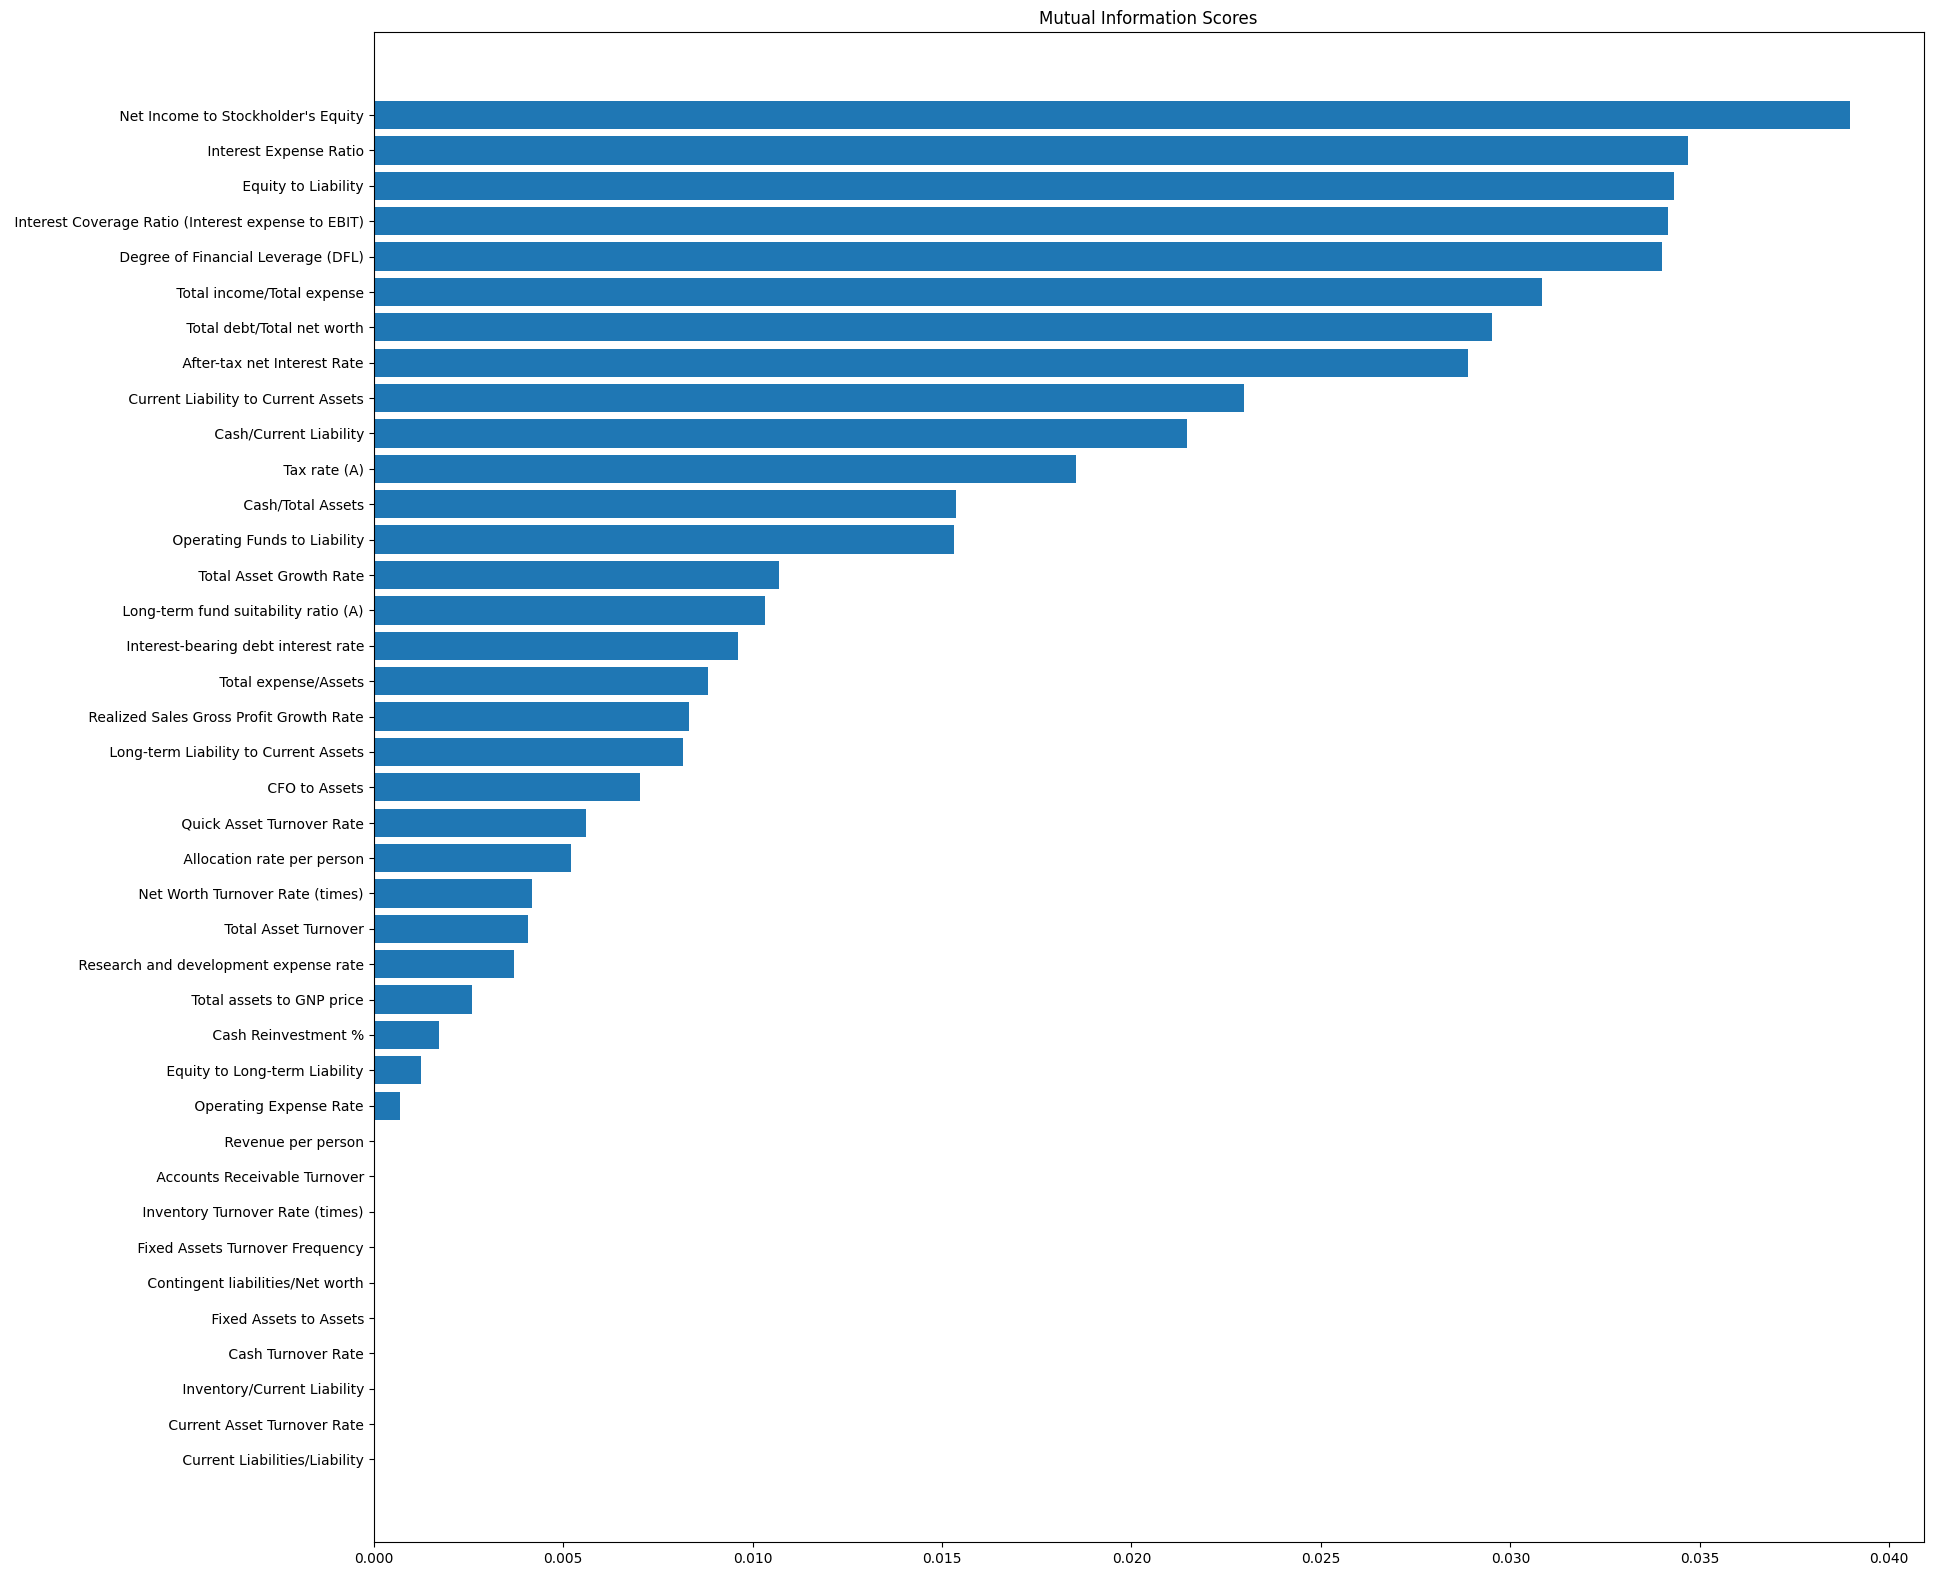

In [297]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(20, 20))
plot_mi_scores(mi_scores)

In [298]:
scaled_df.shape

(6819, 40)

In [228]:
n_features = range(10, 40, 1)
for i in n_features:
    select = RFE(xgb.XGBClassifier(), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)
    model = xgb.XGBClassifier().fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe)
    score = f1_score(preds, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.290  number of features: 10
Test score: 0.267  number of features: 11
Test score: 0.179  number of features: 12
Test score: 0.109  number of features: 13
Test score: 0.281  number of features: 14
Test score: 0.295  number of features: 15
Test score: 0.339  number of features: 16
Test score: 0.241  number of features: 17
Test score: 0.305  number of features: 18
Test score: 0.333  number of features: 19
Test score: 0.369  number of features: 20
Test score: 0.300  number of features: 21
Test score: 0.295  number of features: 22
Test score: 0.339  number of features: 23
Test score: 0.300  number of features: 24
Test score: 0.393  number of features: 25
Test score: 0.259  number of features: 26
Test score: 0.255  number of features: 27
Test score: 0.310  number of features: 28
Test score: 0.327  number of features: 29
Test score: 0.255  number of features: 30
Test score: 0.367  number of features: 31
Test score: 0.361  number of features: 32
Test score: 0.255  number of featu

In [315]:
n_features_to_select = 40
rfe = RFE(xgb.XGBClassifier(), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            gamma=None, gpu_id=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None, ...),
    n_features_to_select=40)

In [316]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1  After-tax net Interest Rate
1  Operating Expense Rate
1  Research and development expense rate
1  Interest-bearing debt interest rate
1  Tax rate (A)
1  Realized Sales Gross Profit Growth Rate
1  Total Asset Growth Rate
1  Cash Reinvestment %
1  Interest Expense Ratio
1  Total debt/Total net worth
1  Long-term fund suitability ratio (A)
1  Contingent liabilities/Net worth
1  Total Asset Turnover
1  Accounts Receivable Turnover
1  Inventory Turnover Rate (times)
1  Fixed Assets Turnover Frequency
1  Net Worth Turnover Rate (times)
1  Revenue per person
1  Allocation rate per person
1  Cash/Total Assets
1  Cash/Current Liability
1  Operating Funds to Liability
1  Inventory/Current Liability
1  Current Liabilities/Liability
1  Long-term Liability to Current Assets
1  Total income/Total expense
1  Total expense/Assets
1  Current Asset Turnover Rate
1  Quick Asset Turnover Rate
1  Cash Turnover Rate
1  Fixed Assets to Assets
1  Equity to Long-term Liability
1  CFO to Assets
1  Current Li

In [323]:
scaled_df.drop(' Equity to Liability', axis=1, inplace=True)

In [324]:
predictions = rfe.predict(X_test)

In [325]:
print(confusion_matrix(predictions, y_test))

[[1314   34]
 [   8    8]]


In [326]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1360
           1       0.07      0.75      0.13         4

    accuracy                           0.97      1364
   macro avg       0.54      0.86      0.56      1364
weighted avg       1.00      0.97      0.98      1364



In [330]:
def optimize(params, X, y):
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=2)
    f1_scores = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, pred))
    return np.mean(f1_scores)

In [362]:
param_space = {
    'eta': scope.int(hp.quniform('eta', 0.1, 0.9, 0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 21, 1)),
    'max_leaves': scope.int(hp.quniform('max_leaves', 10, 100, 10))
}

optimization_function = partial(optimize, X=X, y=y)
trials = Trials()
results = fmin(
    fn=optimization_function,
    space=param_space,
    max_evals=20,
    trials=trials,
    algo=tpe.suggest
)

100%|███████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.86s/trial, best loss: 0.0]


In [363]:
results

{'eta': 0.7000000000000001, 'max_depth': 19.0, 'max_leaves': 40.0}

In [377]:
scaler = RobustScaler()
model_xgb = xgb.XGBClassifier(eta=0.7000000000000001, max_leaves=40, max_depth=19, scale_pos_weight=3)

In [378]:
pipe = Pipeline([('scaler', scaler), ('model', model_xgb)])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

In [379]:
print(confusion_matrix(preds, y_test))

[[1323   23]
 [   9    9]]


In [380]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1346
           1       0.28      0.50      0.36        18

    accuracy                           0.98      1364
   macro avg       0.64      0.74      0.67      1364
weighted avg       0.98      0.98      0.98      1364



In [381]:
X_resampled, y_resampled = ADASYN(sampling_strategy='minority').fit_resample(X, y)

In [383]:
splits = 2
skf = StratifiedKFold(n_splits=splits)
for fold, (train_idx, test_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

In [384]:
scaler = RobustScaler()
model_xgb = xgb.XGBClassifier()

In [385]:
pipe = Pipeline([('scaler', scaler), ('model', model_xgb)])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

In [386]:
print(confusion_matrix(preds, y_test))

[[3231   52]
 [  68 3268]]


In [387]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3283
           1       0.98      0.98      0.98      3336

    accuracy                           0.98      6619
   macro avg       0.98      0.98      0.98      6619
weighted avg       0.98      0.98      0.98      6619



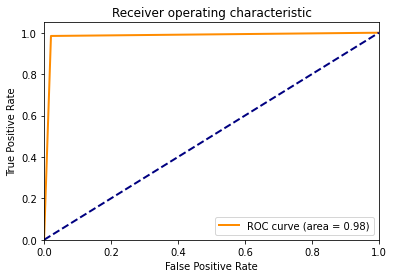

In [388]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [389]:
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold

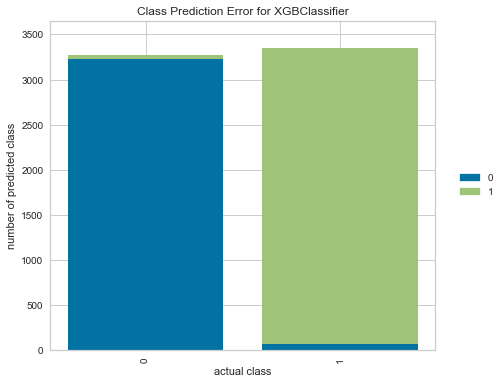

<AxesSubplot:title={'center':'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [391]:
model_xgb = xgb.XGBClassifier()
visualizer = ClassPredictionError(model_xgb)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show() 

In [396]:
import shap

In [397]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


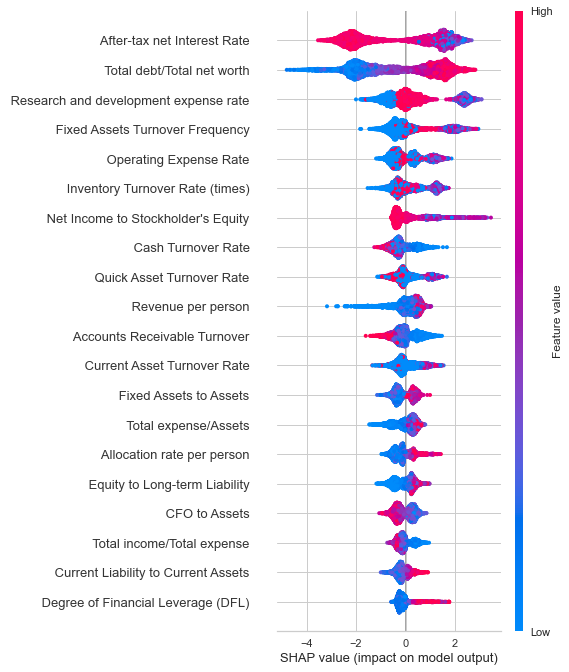

<Figure size 576x396 with 0 Axes>

In [399]:
shap.summary_plot(shap_values, X_test)
plt.show()